# Bug-Repair Project

In [ ]:
__author__ = "Guy Barel"
__email__ = "guybare@post.bgu.ac.il"

## Introduction

When managing a software project, it is common using a version management system like git and a bug tracking system like Jira. Then, a bug description is added to the tracker when a bug occurs. Each bug description has several textual properties. When a bug is found in a certain function, it can be solved by various changes. For example, any change can be defined by the lines added or removed, the number of functions changed, Etc.

In this project, I would like to find the connection between the description of the bug, the faulty function, and the actions taken to fix the bug to build a Machine Learning model that can recommend those actions.

### Dataset Information

The Data Set contains a list of buggy files from the bug management system and their properties, like the functions that were changed to fix them, and the change patterns needed to fix them, and Etc.

A site from which a list of bugfix templates can be extracted- [defects4j](http://program-repair.org/defects4j-dissection/#!/)




## 0 - Setup

#### **Import & Install pckgs**

In [ ]:
!pip install kmodes
!pip install tensorflow scikeras scikit-learn
!pip install tensorflow scikit-learn keras-tuner
!pip install xgboost scikit-learn
!pip install tqdm

In [2]:
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import tensorflow as tf
from tqdm import tqdm
import sklearn.externals
import joblib
from joblib import Parallel, delayed
from joblib import parallel_backend
from sklearn.metrics import make_scorer, f1_score
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# from pandas_profiling import ProfileReport
import numpy as np
from numpy import mean, std
from scipy.stats import chi2_contingency
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches
from sklearn.decomposition import PCA
from sklearn import preprocessing
import networkx as nx
import copy
import json
from numpy import unique
from sklearn.preprocessing import StandardScaler
from numpy import where
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from tensorflow.keras import models, layers, utils, backend
from keras.models import Sequential
import os
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
pd.set_option('display.max_rows', None)
from sklearn.ensemble import RandomForestRegressor
from IPython.display import Markdown, display
from itertools import combinations
from kmodes.kmodes import KModes
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from scipy.sparse import csr_matrix, lil_matrix
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
import random
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_selection import SelectFromModel
from sklearn.dummy import DummyClassifier
import scipy.stats as ss
from networkx.algorithms.community import louvain_communities
from imblearn.over_sampling import SMOTE
%matplotlib inline

#### **Import data**

In [3]:
df = pd.read_csv('just_bugs.csv')
df.shape

(1042, 555)

In [4]:
df.head(n=5)

,commit,file_name,parent_changed_lines,parent_used_lines,parent_changed_used_lines,parent_methods_used_lines,parent_methods_changed_used_lines,parent_methods_count,parent_lines_hunks,parent_used_lines_hunks,...,ast_diff_retRem,ast_diff_retExpChange,ast_diff_varAdd,ast_diff_varRem,ast_diff_varTyChange,ast_diff_varModChange,ast_diff_varReplVar,ast_diff_varReplMc,ast_diff_tyAdd,ast_diff_tyImpInterf
0,9345b31d1511906438eeb796b26ee65dbe964561,src/java/org/apache/commons/lang/exception/Exc...,1,325,1,283,1,23,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,097aa30a36a6ed2e53fc81b1fde53009f2f3e8ad,src/java/org/apache/commons/lang/ArrayUtils.java,3,1427,3,1396,3,155,1,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,097aa30a36a6ed2e53fc81b1fde53009f2f3e8ad,src/test/org/apache/commons/lang/ArrayUtilsTes...,47,2015,47,2018,47,129,10,10,...,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0
3,beed062120fcde8166d004244f04011158304e2a,src/java/org/apache/commons/lang/StringUtils.java,0,1498,0,1483,0,132,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,dd2a1841fc7c9c95af1ce1e6ed3ed0ee3587df19,src/java/org/apache/commons/lang/time/Duration...,2,345,2,325,2,19,2,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 1 - Exploratory Data Analysis

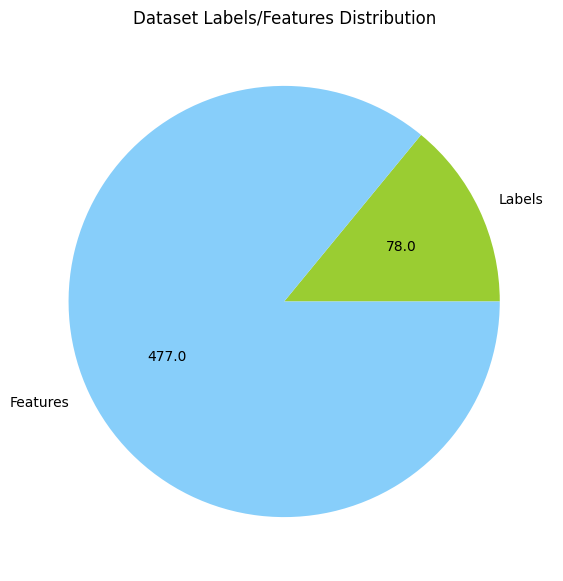

In [5]:
num_labels = len(df[df.columns[df.columns.to_series().str.contains('ast_diff')]].columns)
num_features = len(df[df.columns[~df.columns.to_series().str.contains('ast_diff')]].columns)

labels = ['Labels', 'Features']
sizes = np.array([num_labels, num_features])
colors = ['yellowgreen', 'lightskyblue']


# Creating plot
fig = plt.figure(figsize =(10, 7))
plt.title("Dataset Labels/Features Distribution")
plt.pie(sizes, labels = labels, autopct=lambda val: np.round(val/100.*sizes.sum(), 0), colors=colors)

# show plot
plt.show()

--> The dataset contains 1042 commits (rows) and 555 variables (477 features + 78 labels)

Basic dataset information

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1042 entries, 0 to 1041
Columns: 555 entries, commit to ast_diff_tyImpInterf
dtypes: float64(164), int64(389), object(2)
memory usage: 4.4+ MB


There are 2 variebles of type object, so i want to take a look at their cardinality:

In [7]:
df.select_dtypes(include='object').head(n=5)

,commit,file_name
0,9345b31d1511906438eeb796b26ee65dbe964561,src/java/org/apache/commons/lang/exception/Exc...
1,097aa30a36a6ed2e53fc81b1fde53009f2f3e8ad,src/java/org/apache/commons/lang/ArrayUtils.java
2,097aa30a36a6ed2e53fc81b1fde53009f2f3e8ad,src/test/org/apache/commons/lang/ArrayUtilsTes...
3,beed062120fcde8166d004244f04011158304e2a,src/java/org/apache/commons/lang/StringUtils.java
4,dd2a1841fc7c9c95af1ce1e6ed3ed0ee3587df19,src/java/org/apache/commons/lang/time/Duration...


In [8]:
df[['commit','file_name']].describe().head(n=5)

,commit,file_name
count,1042,1042
unique,682,299
top,ab66a1d87cc37e41940bfde98a55066c35ca0f75,src/main/java/org/apache/commons/lang3/StringU...
freq,5,75


Dou their relative high cardinality, i decide to remove this features

In [9]:
df = df.drop(columns=['commit', 'file_name'])
df.shape

(1042, 553)

### **1.1. Data Cleaning**

Checking for rows with missing values:

In [ ]:
df.isnull().sum()

Removing rows with missing values:

In [11]:
df.dropna(inplace=True)
df.shape

(1041, 553)

Checking for duplicate rows:

In [12]:
df.duplicated().sum()

5

Removing duplicates rows:

In [13]:
df.drop_duplicates(inplace = True)
df.shape

(1036, 553)

Remove all columns with more than 85% empty values:

In [14]:
for colname, coldata in df.items():
    if (df[colname] == 0).astype(int).sum(axis=0)/len(df) > 0.85:
        df.drop(colname, inplace = True, axis = 1)
df.shape

(1036, 282)

Labeling all samplse that not using any af the lables as 'other'

In [15]:
# Initialize the 'other' column with default value 0
df['ast_diff_other'] = 0.0

# Iterate through the DataFrame
for i, row in df.loc[:, 'ast_diff_assignAdd': ].iterrows():
    # Check if all values in the row are zero
    if (row == 0).astype(int).all():
        # Update the 'other' column for this row
        df.at[i, 'ast_diff_other'] = 1.0

# Check the shape of the DataFrame
df.shape

(1036, 283)

In [16]:
df.head()

,parent_changed_lines,parent_used_lines,parent_changed_used_lines,parent_methods_used_lines,parent_methods_changed_used_lines,parent_methods_count,parent_lines_hunks,parent_used_lines_hunks,parent_CCN,parent_average_cyclomatic_complexity,...,ast_diff_mcRem,ast_diff_mcParAdd,ast_diff_mcParRem,ast_diff_mcParValChange,ast_diff_mdAdd,ast_diff_objInstAdd,ast_diff_objInstMod,ast_diff_retBranchAdd,ast_diff_varAdd,ast_diff_other
0,1,325,1,283,1,23,1,1,94,3.760000,...,0.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3,1427,3,1396,3,155,1,1,519,3.326923,...,1.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2,47,2015,47,2018,47,129,10,10,140,1.129032,...,52.0,0.0,77.0,172.0,0.0,0.0,9.0,0.0,0.0,0.0
3,0,1498,0,1483,0,132,0,0,519,3.902256,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2,345,2,325,2,19,2,2,89,4.450000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#### X / y Splitt

In [17]:
# Find the index of the first column starting with 'ast_diff_'
ast_diff_col_index = next((i for i, col in enumerate(df.columns) if col.startswith('ast_diff_')), None)

# Check if such a column was found
if ast_diff_col_index is not None:
    # Create df_x with columns before the 'ast_diff_' column
    df_x = df.iloc[:, :ast_diff_col_index]

    # Create df_y with columns from 'ast_diff_' to the end
    df_y = df.iloc[:, ast_diff_col_index:]

    # Rename the columns in df_y by removing 'ast_diff_' prefix
    df_y = df_y.rename(columns=lambda x: x.split("ast_diff_")[1])
else:
    # Handle the case where no 'ast_diff_' column was found
    print("No column starting with 'ast_diff_' found.")
    df_x = df.copy()
    df_y = pd.DataFrame()

print(df_y.shape, df_x.shape)

(1036, 13) (1036, 270)


In [18]:
df_y.head()

,assignAdd,condBranIfAdd,mcAdd,mcRem,mcParAdd,mcParRem,mcParValChange,mdAdd,objInstAdd,objInstMod,retBranchAdd,varAdd,other
0,0.0,0.0,2.0,0.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,52.0,0.0,77.0,172.0,0.0,0.0,9.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### **1.2. Labels Analysis**

Calculating number of files under each label

In [19]:
categories = list(df_y.columns.values)
# print(categories)

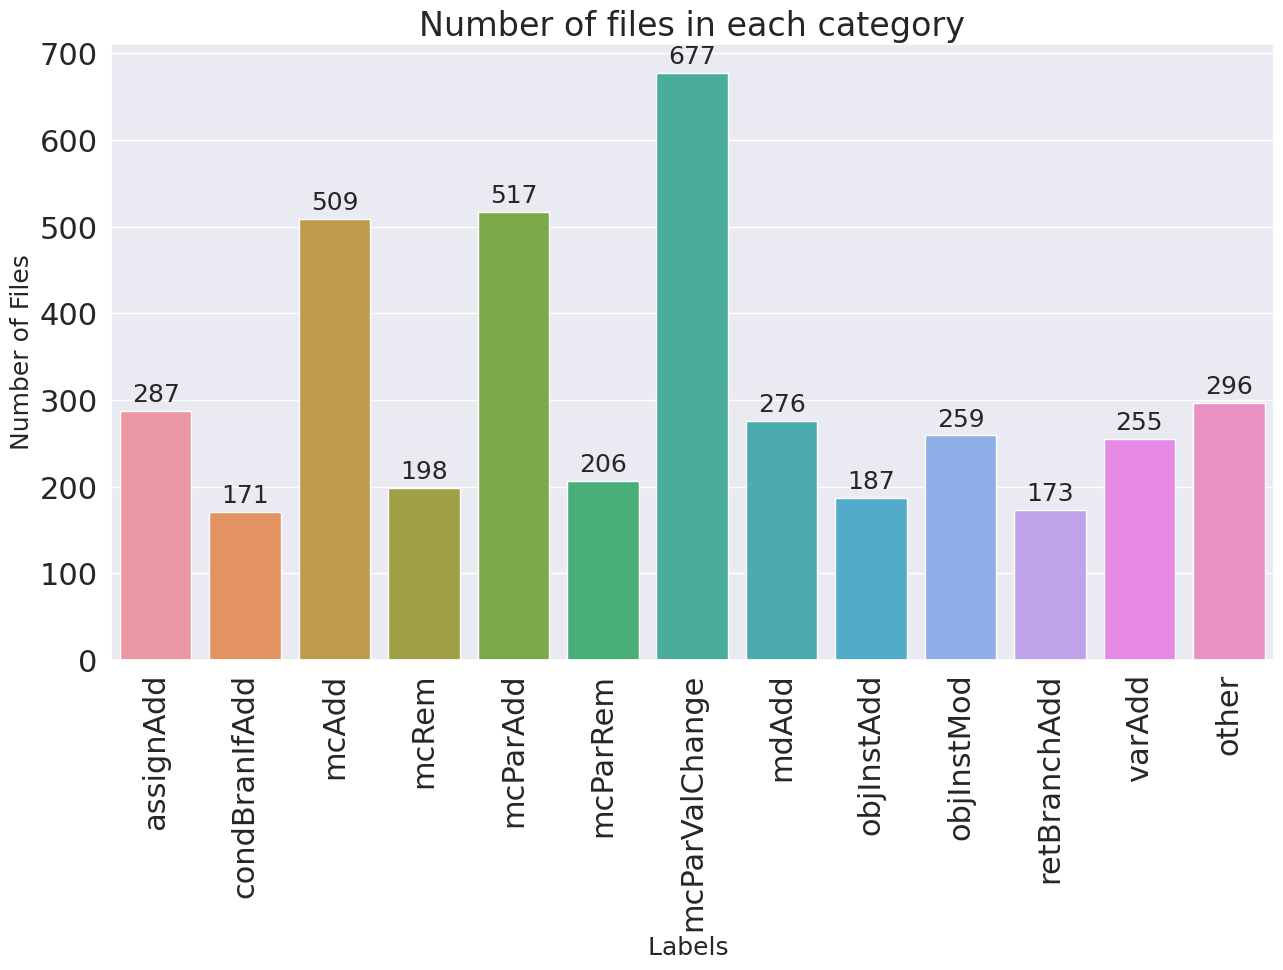

In [20]:
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
ax= sns.barplot(x=categories, y=df_y.astype(bool).sum().values)
plt.title("Number of files in each category", fontsize=24)
plt.ylabel('Number of Files', fontsize=18)
plt.xlabel('Labels ', fontsize=18)

#adding the text labels
rects = ax.patches
labels = df_y.astype(bool).sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)
plt.xticks(rotation = 90)
plt.show()

Labels interpetation:


*   assignAdd - Assignment addition
*   CondBranIfAdd - Conditional (if) branch addition
*   mcAdd - Method call addition
*   mcRem - Method definition removal
*   mcParAdd - Method call parameter addition
*   mcParRem - Method call parameter removel
*   mcParValChange - Method call parameter value modification
*   mdAdd - Method definition addition
*   objInstAdd - Object instantiation addition
*   objInstMod - Object instantiation modification
*   retBranchAdd - Return statement addition
*   varAdd - Variable addition



Labels Cardinality

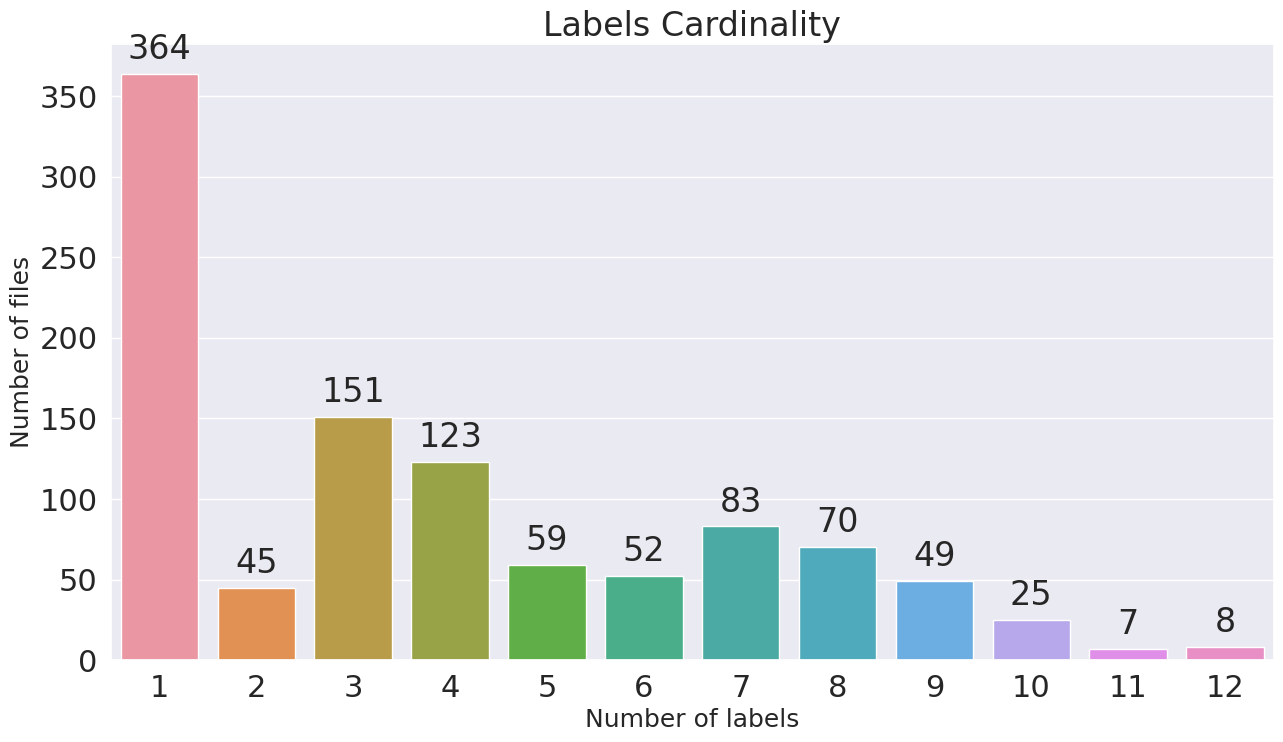

In [21]:
rowSums = df_y.astype(bool).sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts.sort_index(inplace = True)

sns.set(font_scale = 2)
plt.figure(figsize=(15,8))

ax = sns.barplot(x=multiLabel_counts.index, y=multiLabel_counts.values)

plt.title("Labels Cardinality")
plt.ylabel('Number of files', fontsize=18)
plt.xlabel('Number of labels', fontsize=18)

#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

Changing the labels to binary representation:

In [22]:
df_y = df_y.astype(bool).astype(int)
df_y.head()

,assignAdd,condBranIfAdd,mcAdd,mcRem,mcParAdd,mcParRem,mcParValChange,mdAdd,objInstAdd,objInstMod,retBranchAdd,varAdd,other
0,0,0,1,0,1,0,1,0,0,0,0,0,0
1,0,0,0,1,0,1,1,0,0,0,0,0,0
2,0,0,0,1,0,1,1,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,1


#### Multi-label Feature Selection

The task of multi-label feature selection (MLFS) is to reduce redundant information and generate the optimal feature subset from the original multi-label data.

Exploring label correlations is a necessary module for MLFS. In reality, the label correlations of multi-label data may be beyond the second-order relationship (i.e., the label pair). In other words, there are the correlations between the label sets in the multi-label data. In the section below, i will try 3 diffrenet techniqe for the FS phase.

Labels Correlations tests:

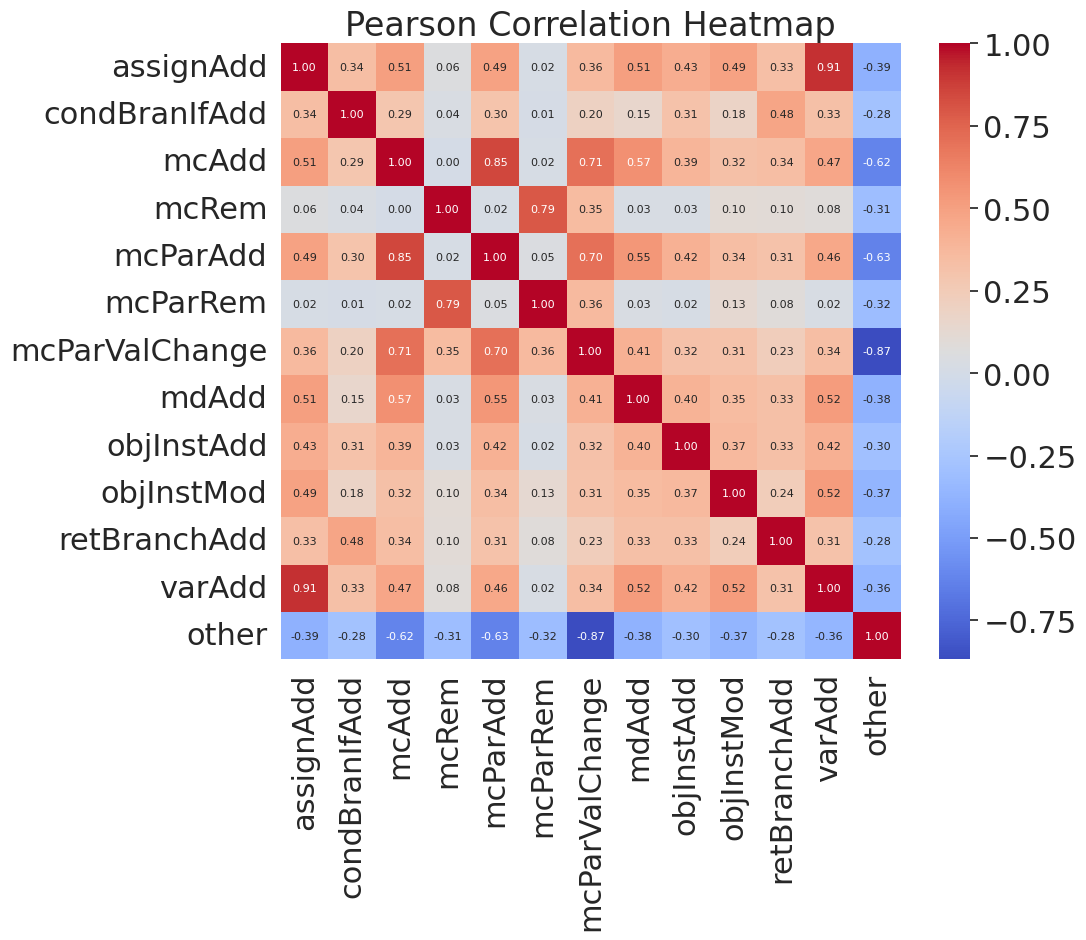

In [23]:
# Pearson Correlation
plt.figure(figsize=(10, 8))
sns.heatmap(df_y.corr(method='pearson'), annot=True, fmt=".2f", cmap="coolwarm", annot_kws={"size": 8})
plt.title("Pearson Correlation Heatmap")
plt.show()

In [ ]:
# def cramers_v(x, y):
#     confusion_matrix = pd.crosstab(x, y)
#     chi2 = chi2_contingency(confusion_matrix)[0]
#     n = confusion_matrix.sum().sum()
#     phi2 = chi2 / n
#     r, k = confusion_matrix.shape
#     phi2_corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
#     r_corr = r - ((r-1)**2)/(n-1)
#     k_corr = k - ((k-1)**2)/(n-1)
#     return np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))

# # Calculate Cramér's V for each pair of labels
# num_labels = df_y.shape[1]
# cramers_v_matrix = pd.DataFrame(np.zeros((num_labels, num_labels)), index=df_y.columns, columns=df_y.columns)

# for col1 in df_y.columns:
#     for col2 in df_y.columns:
#         cramers_v_matrix.loc[col1, col2] = cramers_v(df_y[col1], df_y[col2])


# plt.figure(figsize=(10, 8))
# sns.heatmap(cramers_v_matrix, annot=True, fmt=".2f", cmap="viridis", annot_kws={"size": 8})
# plt.title("Cramér's V Correlation Heatmap")
# plt.show()

#### 1. K-Modes Clustering

I will first explore the latent semantic structure according to spectral clustering. First The labels are abstracted into several clusters. Second, the importance of features with respect to the labels in each cluster is scored using Random Forest. Finally, obtain the feature subset based on the scores of features.

Given the fact that the labels are categorical variables, I will perform k-modes clustering. The difference between k-means and k-modes lies in the metric used for clustering. Where k-means uses a distance metric between two objects to cluster similar datapoints, k-modes utilizes the total number of mismatches between two objects. In other words, it uses a mode metric instead of a mean distance metric.

##### Elbow curve to find optimal K value:

First, let's do a sweep of the number of clusters and look at how cost changes as we increase the cluster number. I will be using the elbow method to determine the optimal number of clusters. The elbow of the cost (the sum of all the dissimilarities between the clusters) plot represents the point where we stop seeing significant improvement in our clustering cost function as we continue to increase the number of clusters.

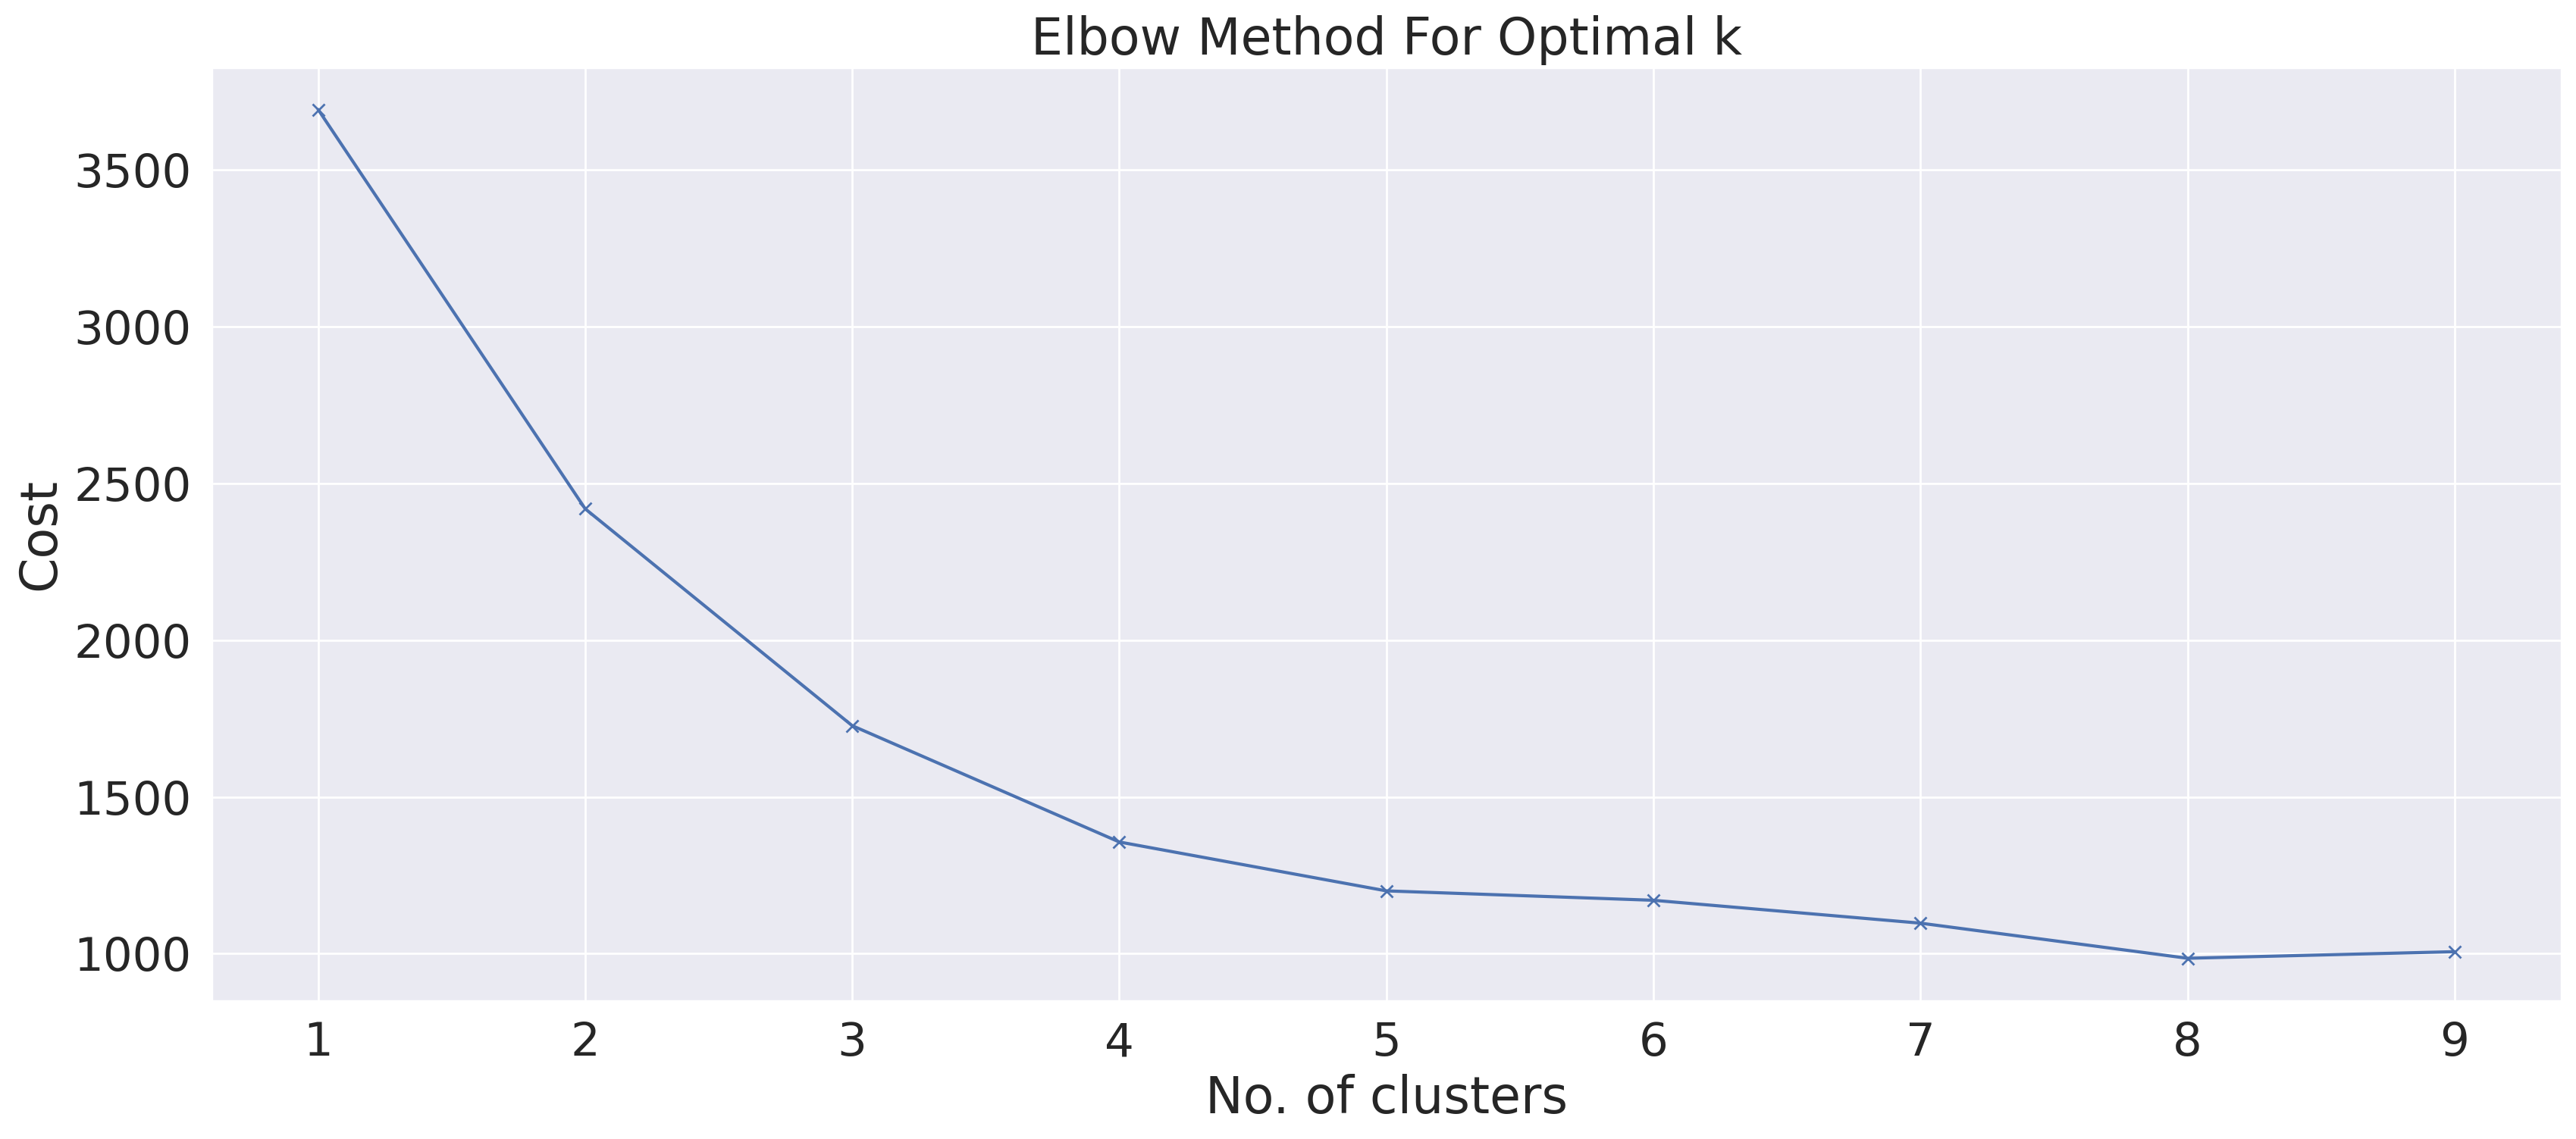

In [24]:
cost = []
K = range(1,10)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 10, verbose=0)
    kmode.fit_predict(df_y)
    cost.append(kmode.cost_)


figure(figsize=(20, 8), dpi=200)
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

According to the scree plot above, I consider choosing k=5 for the cluster analysis. It means we will have six groups of fixing methods based on labels characteristics.

##### Building the K-Mode model with 5 clusters:

In [25]:
kmode = KModes(n_clusters=5, init = "random", n_init = 10, verbose=0)
clusters = kmode.fit_predict(df_y)
kmode_labels = pd.DataFrame(list(clusters.astype(int)),columns=['Cluster'])

##### Cluster Visualization

In order to determine any trends or insights from the clustered data, we can look at count plots for each label.

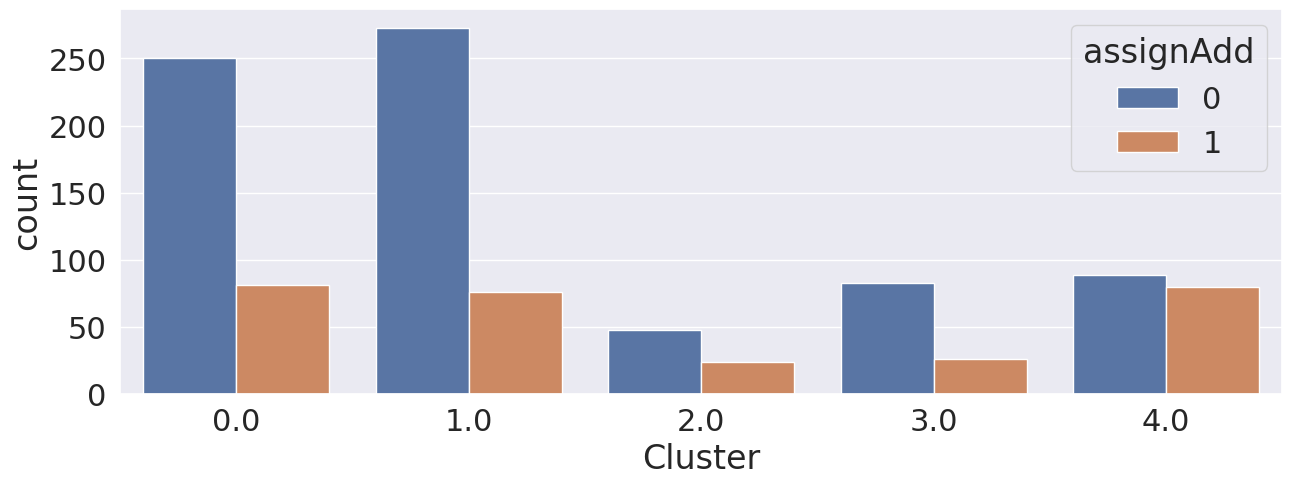

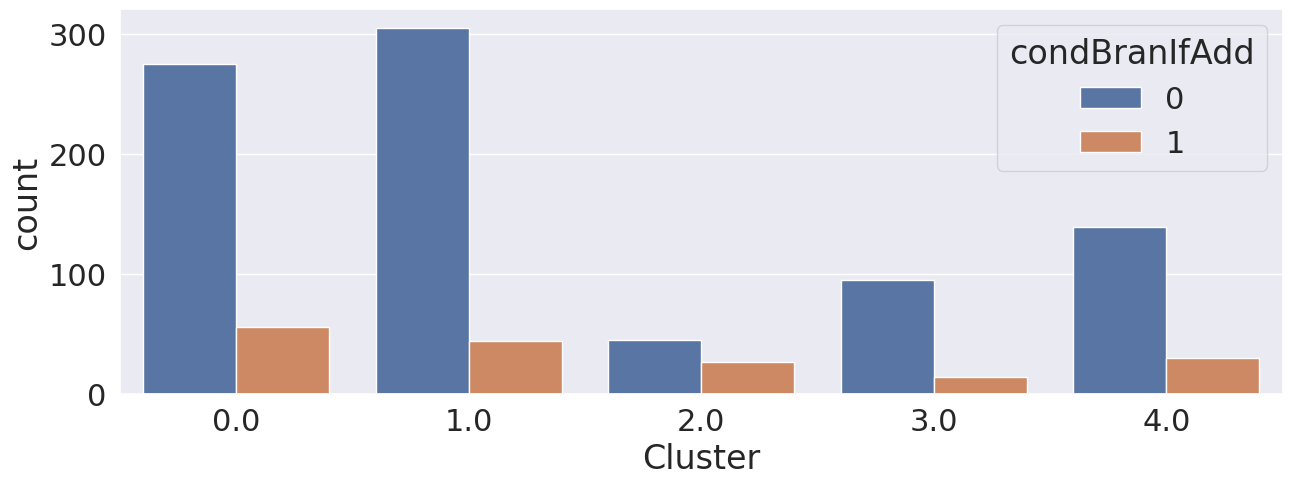

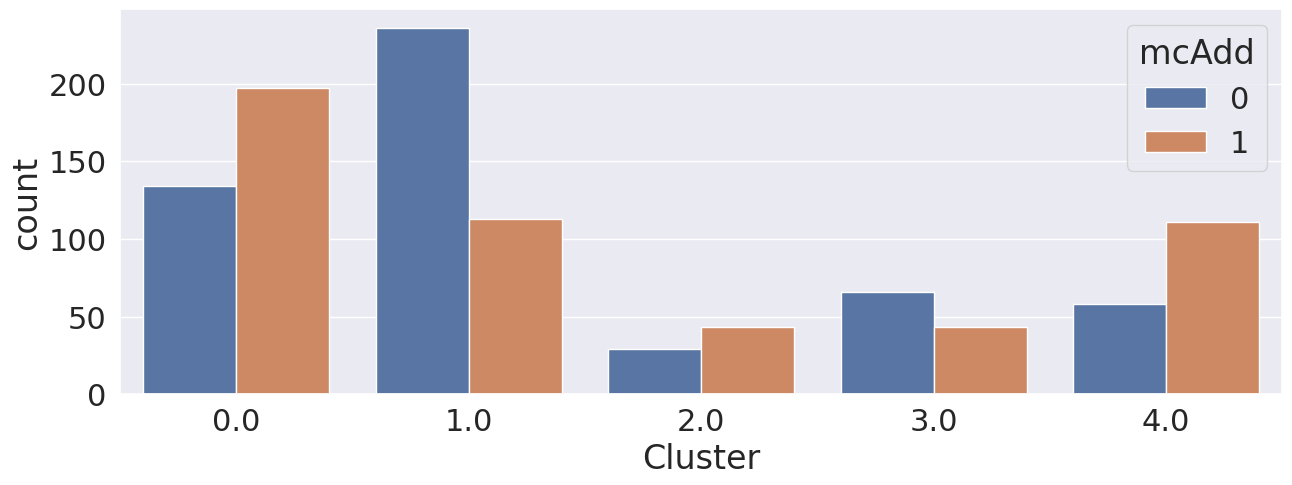

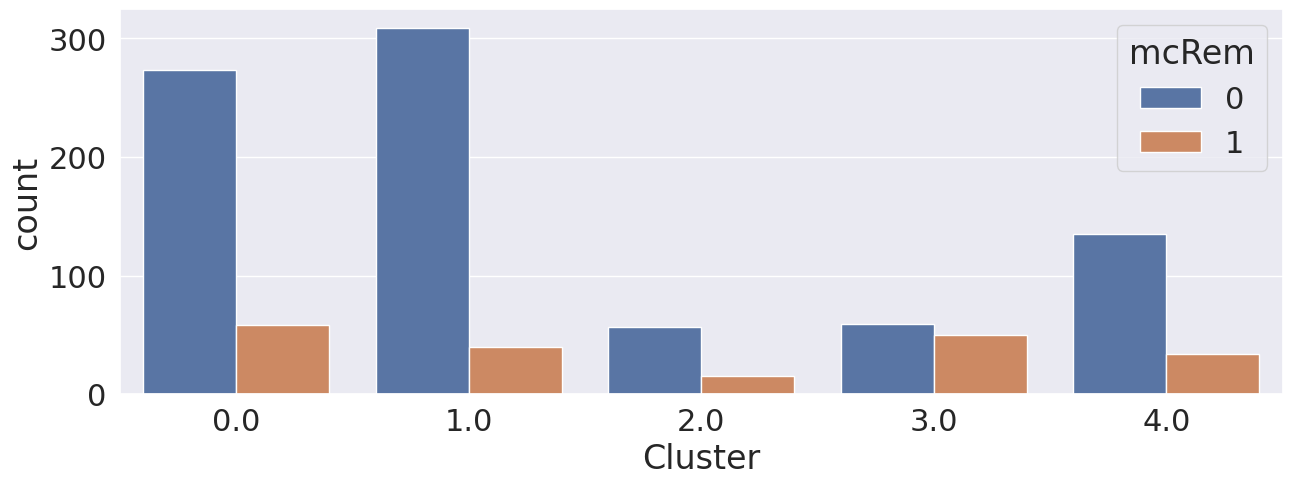

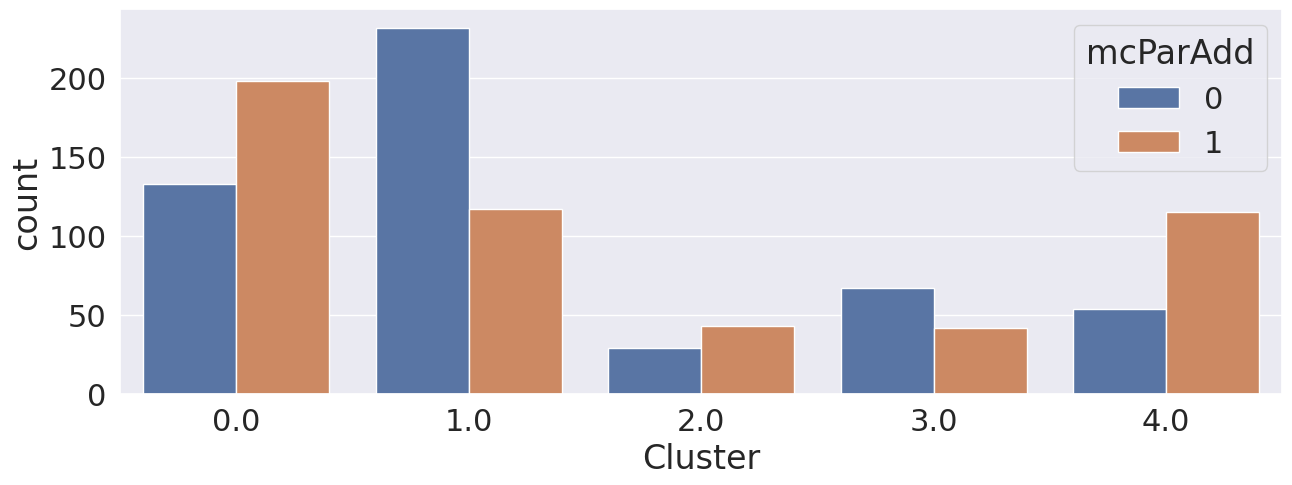

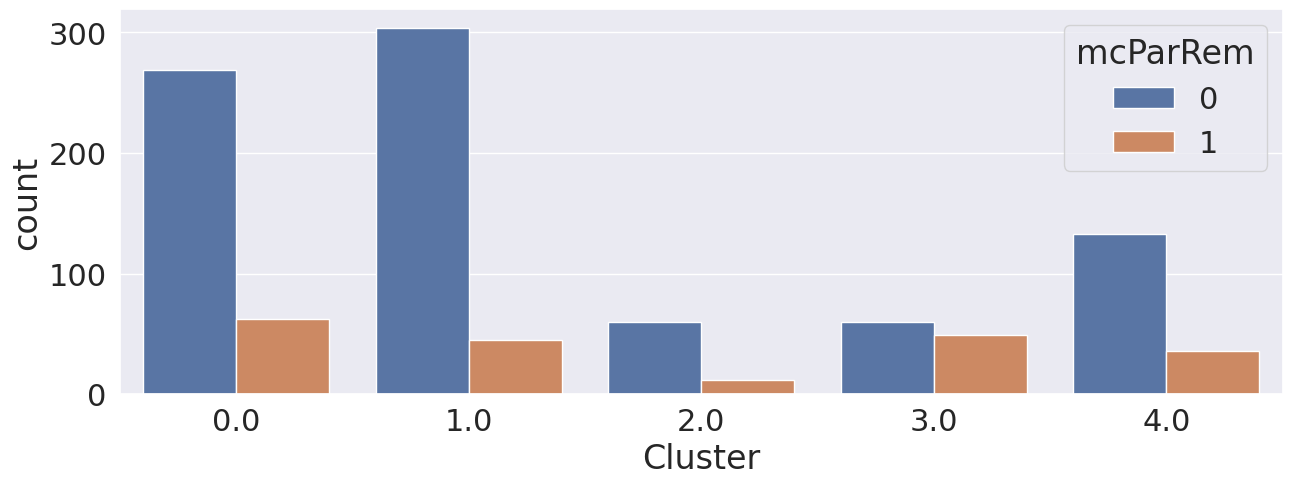

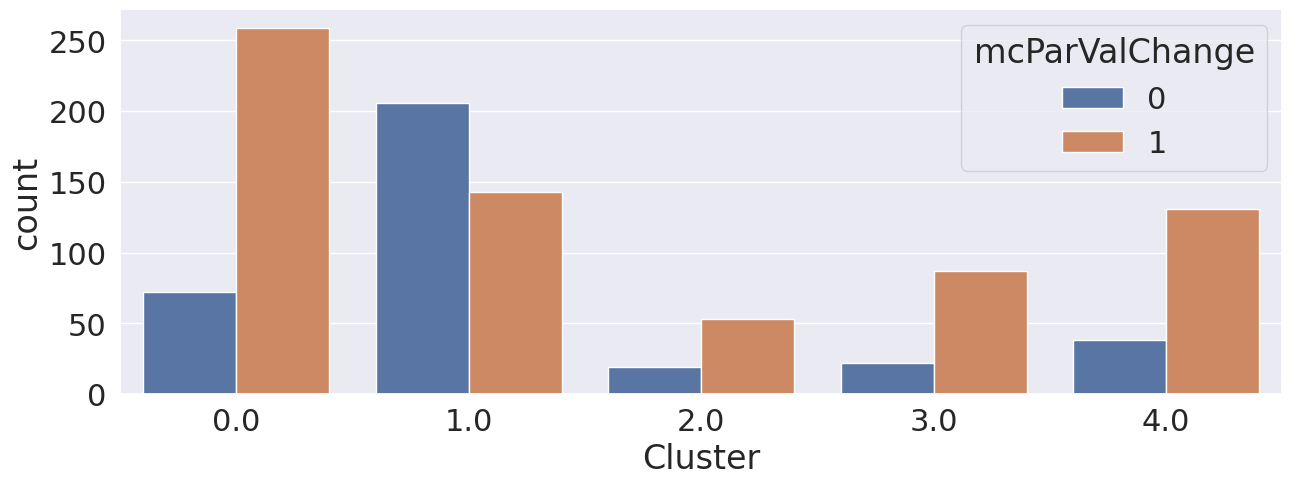

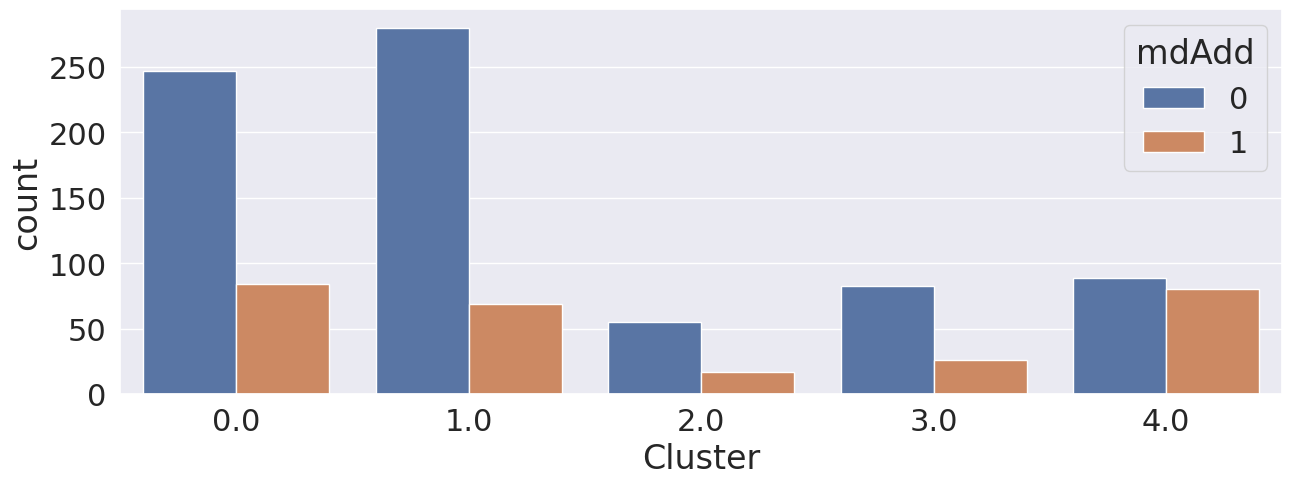

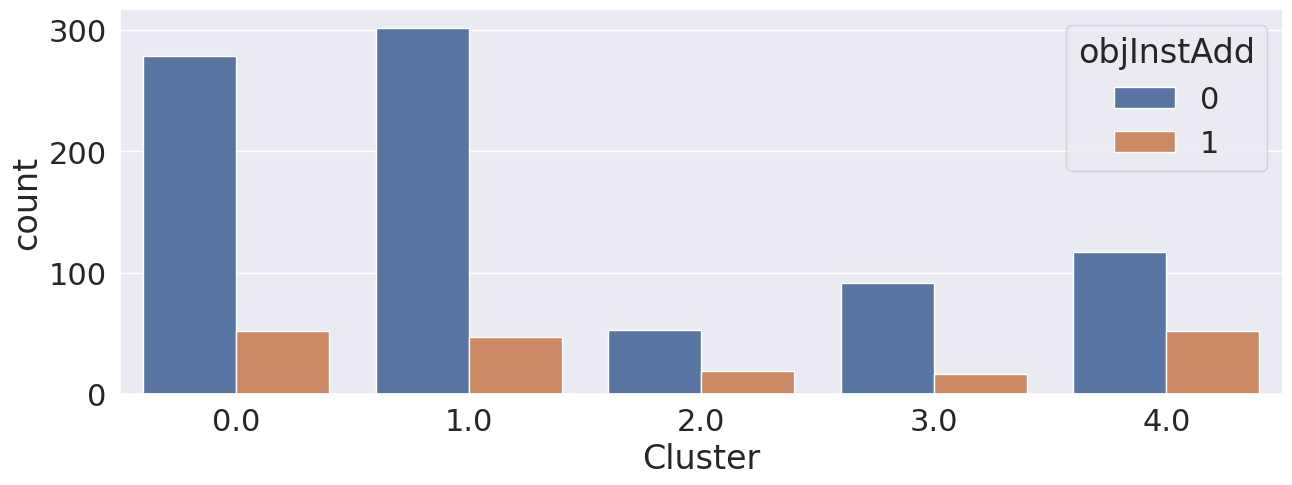

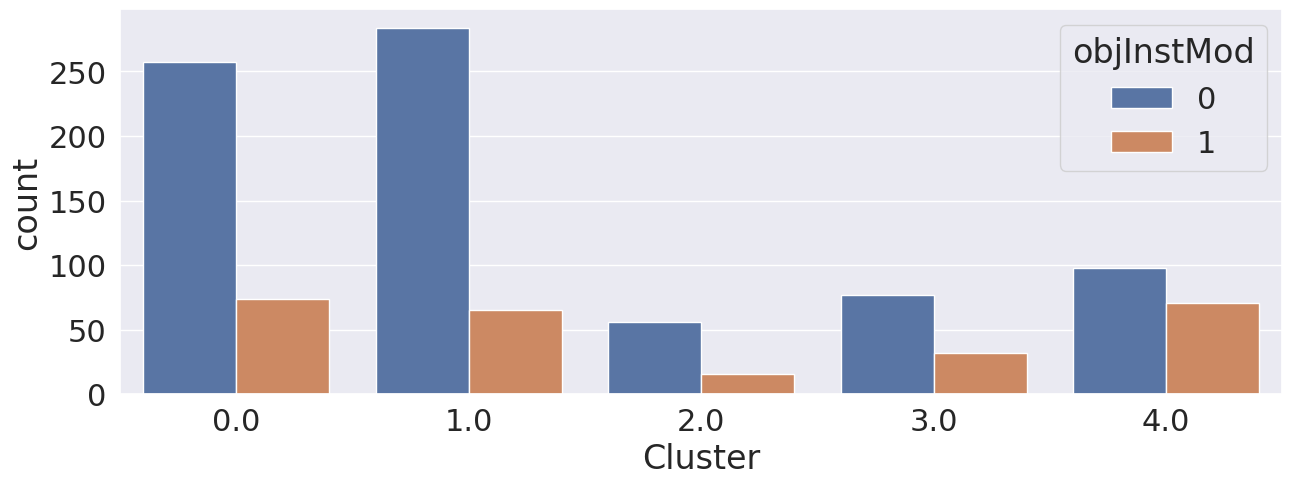

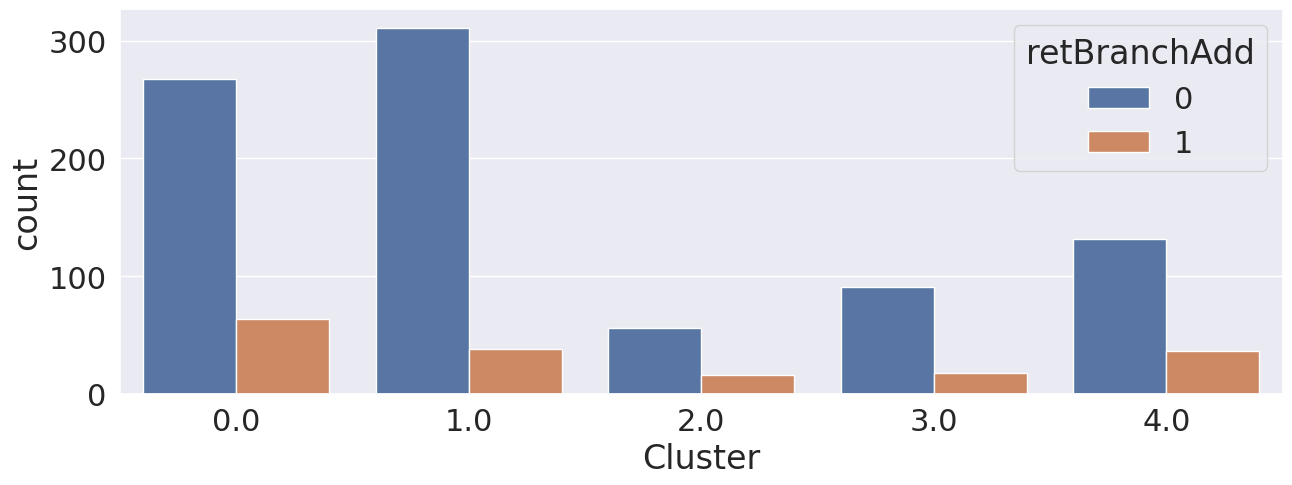

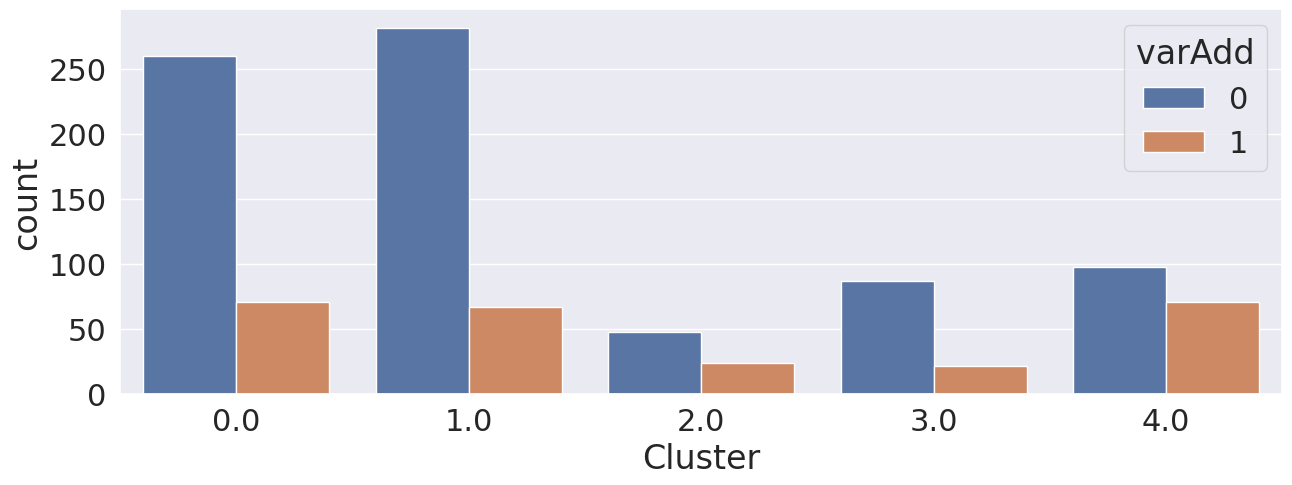

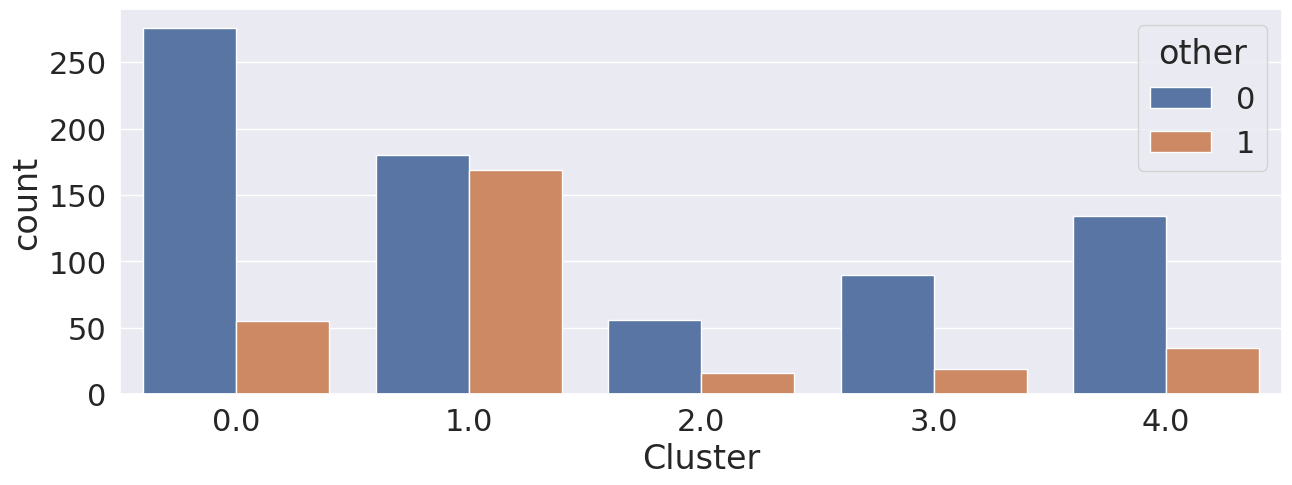

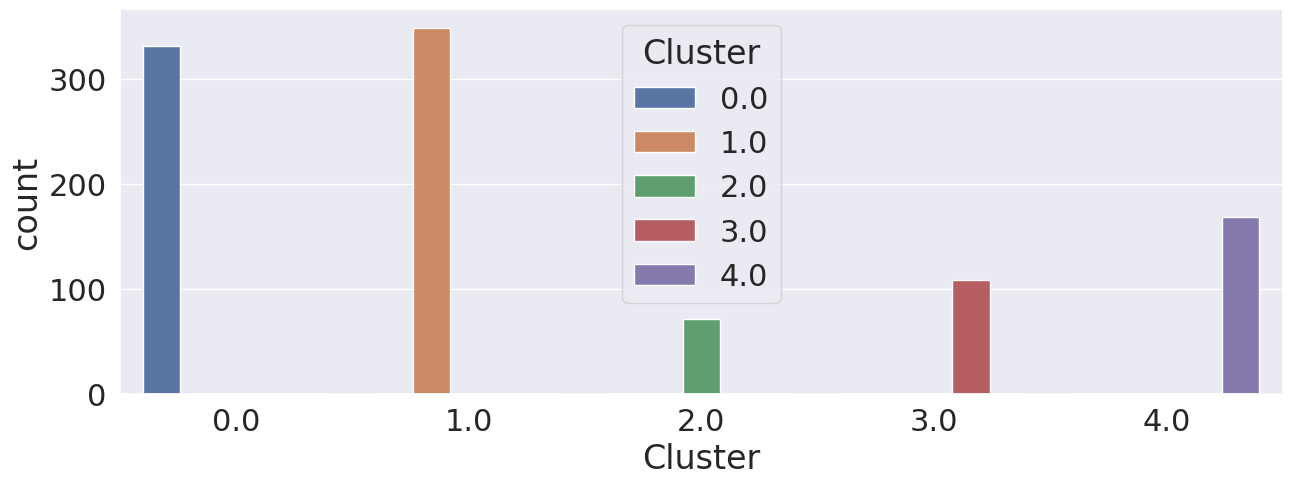

In [26]:
kmode_y = df_y.join(kmode_labels)

for col in kmode_y:
    plt.subplots(figsize = (15,5))
    sns.countplot(x='Cluster',hue=col, data = kmode_y)
    plt.show()

In [27]:
# Group data by cluster
grouped = kmode_y.groupby('Cluster')

# Calculate mode for each label within each cluster
label_modes = grouped.agg(pd.Series.mode)

# Print the mode of labels in each cluster
label_modes

,assignAdd,condBranIfAdd,mcAdd,mcRem,mcParAdd,mcParRem,mcParValChange,mdAdd,objInstAdd,objInstMod,retBranchAdd,varAdd,other
Cluster,,,,,,,,,,,,,
0.0,0,0,1,0,1,0,1,0,0,0,0,0,0
1.0,0,0,0,0,0,0,0,0,0,0,0,0,0
2.0,0,0,1,0,1,0,1,0,0,0,0,0,0
3.0,0,0,0,0,0,0,1,0,0,0,0,0,0
4.0,0,0,1,0,1,0,1,0,0,0,0,0,0


In [28]:
# Calculate the proportion of each label within each cluster
label_proportions = grouped.mean()
# Print the proportion of labels in each cluster
label_proportions

,assignAdd,condBranIfAdd,mcAdd,mcRem,mcParAdd,mcParRem,mcParValChange,mdAdd,objInstAdd,objInstMod,retBranchAdd,varAdd,other
Cluster,,,,,,,,,,,,,
0.0,0.244713,0.169184,0.595166,0.175227,0.598187,0.187311,0.782477,0.253776,0.157100,0.223565,0.193353,0.214502,0.166163
1.0,0.217765,0.126074,0.323782,0.114613,0.335244,0.128940,0.409742,0.197708,0.134670,0.186246,0.108883,0.191977,0.484241
2.0,0.333333,0.375000,0.597222,0.208333,0.597222,0.166667,0.736111,0.236111,0.263889,0.222222,0.222222,0.333333,0.222222
3.0,0.238532,0.128440,0.394495,0.458716,0.385321,0.449541,0.798165,0.238532,0.155963,0.293578,0.165138,0.201835,0.174312
4.0,0.473373,0.177515,0.656805,0.201183,0.680473,0.213018,0.775148,0.473373,0.307692,0.420118,0.218935,0.420118,0.207101


#### 2. Louvain Communities Detection
In this method, first i calculate the corellation between each of the labels, then i will creat a graph which each label is a node and the edge weight is the corellation coefficient between the two lables. Lastly i will use loavain algorithm in order to detect communities of labels: To find the connection between the lables.  

After that, i will reduce the dimention of each grup to 1d, and test the importance of features with respect to the labels in each group  using Random Forest. Finally, obtain the feature subset based on the scores of features.

Given the fact that the labels are categorical variables, I will use Multiple Correspondence Analysis (MCA) to reduce the categorical labels dimension.

In [29]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

df_s_t_w = pd.DataFrame(columns=['source', 'target', 'weight'])
s, t, w = ([] for i in range(3))

carmers_v_matrix = []
for colname, coldata in df_y.items():
    for colname1, coldata1 in df_y.items():
        if (colname != colname1) and (cramers_v(df_y[colname], df_y[colname1]) > 0.4):
            s.append(colname)
            t.append(colname1)
            w.append(cramers_v(df_y[colname], df_y[colname1]))
#             print(colname,colname1, cramers_v(df_y[colname], df_y[colname1]))

df_s_t_w['source'] = s
df_s_t_w['target'] = t
df_s_t_w['weight'] = w

In [30]:
G = nx.from_pandas_edgelist(df_s_t_w, 'source', 'target', ["weight"])

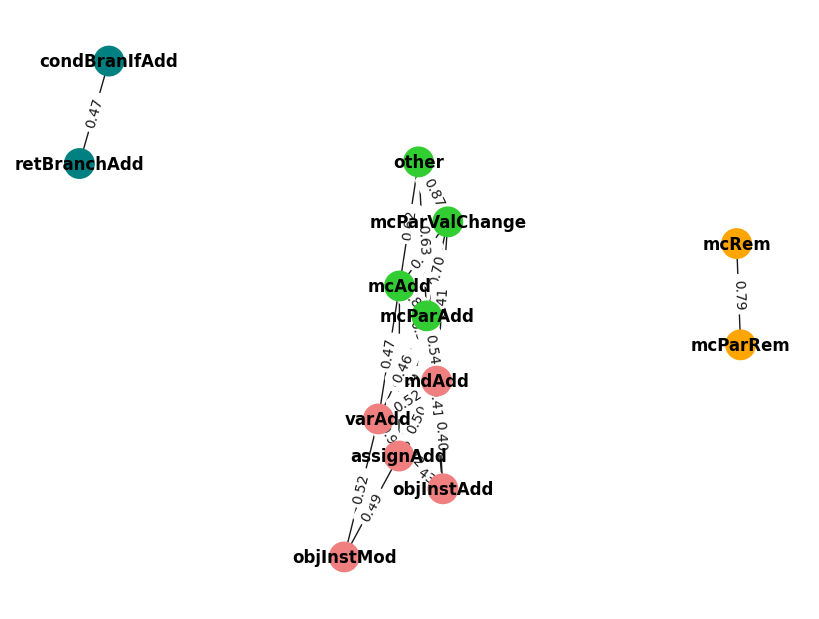

In [31]:
comms = {}
for i, e in enumerate(louvain_communities(G)):
    for l in list(e):
        comms[l] = i

cmap = {
    0 : 'lightcoral',
    1 : 'teal',
    2 : 'limegreen',
    3 : 'orange',
    4 : 'black',
    5 : 'yellow'
}

node_cmap=[cmap[comms.get(node)] for node in G]

# pos = nx.spring_layout(G)
# nx.draw(G, pos, node_size = 75, alpha = 0.8, node_color=node_cmap)
# plt.show()


figure(figsize=(8, 6), dpi=100)
pos = nx.spring_layout(G, seed=123)
# pos=nx.circular_layout(G) #
nx.draw(G, pos, with_labels=True, font_weight='bold',font_color='black',node_color=node_cmap,node_size=450)
# edge_weight = nx.get_edge_attributes(G,'weight')
edge_weight = dict([((u,v,), f"{d['weight']:.2f}") for u,v,d in G.edges(data=True)])
nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_weight)
# plt.suptitle(f'Full interaction graph of {G.number_of_nodes()} users', fontsize=16, y=0.97)
plt.show()

#### **Labels Selection:**

According to the labels analysis above, I decided to combine several labels:

*   assignAdd + varAdd -> varassignAdd
*   CondBranIfAdd + retBranchAdd -> branchAdd
*   mcAdd + mdAdd + mcParValChange + mcParAdd  -> mModification
*   mcRem + mcParRem -> mRem
*   objInstAdd + objInstMod -> objInstChange






In [32]:
# Combining the columns using a logical OR operation and creating a new label
df_y['varassignAdd'] = (df_y['varAdd'] | df_y['assignAdd']).astype(int)
df_y['branchAdd'] = (df_y['condBranIfAdd'] | df_y['retBranchAdd']).astype(int)
df_y['mModification'] = (df_y['mcAdd'] | df_y['mdAdd'] | df_y['mcParValChange'] | df_y['mcParAdd']).astype(int)
df_y['mRem'] = (df_y['mcRem'] | df_y['mcParRem']).astype(int)
df_y['objInstChange'] = (df_y['objInstAdd'] | df_y['objInstMod']).astype(int)

# Removing the old label columns
df_y.drop(['varAdd', 'assignAdd', 'condBranIfAdd', 'retBranchAdd', 'mcAdd', 'mdAdd', 'mcParValChange', 'mcParAdd', 'mcRem', 'mcParRem', 'objInstAdd', 'objInstMod'], axis=1, inplace=True)

df_y.head()

,other,varassignAdd,branchAdd,mModification,mRem,objInstChange
0,0,0,0,1,0,0
1,0,0,0,1,1,0
2,0,0,0,1,1,1
3,1,0,0,0,0,0
4,1,0,0,0,0,0


## 2 - Feature Selection

In [33]:
df_x.head()

,parent_changed_lines,parent_used_lines,parent_changed_used_lines,parent_methods_used_lines,parent_methods_changed_used_lines,parent_methods_count,parent_lines_hunks,parent_used_lines_hunks,parent_CCN,parent_average_cyclomatic_complexity,...,delta_NPM,delta_TNPM,delta_LCOM5,delta_TNLM,delta_McCC,delta_NUMPAR,added_lines+removed_lines,added_lines-removed_lines,used_added_lines+used_removed_lines,used_added_lines-used_removed_lines
0,1,325,1,283,1,23,1,1,94,3.760000,...,0.0,0.0,0.0,0.0,1.0,0.0,2,0,2,0
1,3,1427,3,1396,3,155,1,1,519,3.326923,...,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,3,-3,3,-3
2,47,2015,47,2018,47,129,10,10,140,1.129032,...,-1.0,-1.0,-1.0,-1.0,-2.0,0.0,47,-47,47,-47
3,0,1498,0,1483,0,132,0,0,519,3.902256,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
4,2,345,2,325,2,19,2,2,89,4.450000,...,0.0,0.0,0.0,0.0,0.0,0.0,5,1,5,1


#### Features Correlations tests:

Some independent variables in the dataset might be highly correlated with each other. I will use two metric to evaluate the correlation between the featurs:

- Pearson correlation between features
- Spearman correlation between features

Keeping one of the two features when the correlation is higher then 0.8 between them:

In [34]:
methods = ['pearson', 'spearman']

for method in methods:
    cor_matrix = df_x.corr(method=f'{method}').abs()
    upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]

    df_x.drop(to_drop, axis=1, inplace = True)

df_x.shape

(1036, 45)

-> Many features are highly correlated; eventually, I kept 45 features.

Box plot for detecting outliers:

In [ ]:
continuous_labels = list(df_x.columns)
i = 1
plt.figure(figsize=(20,60))
for var in continuous_labels: #plotting boxplot for each variable
   plt.subplot(round(len(continuous_labels)/4),5,i)
   plt.boxplot(df_x[var],whis=5)
   plt.title(var)
   i+=1
plt.tight_layout()
plt.show()

#### Train/Test split:

In [36]:
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42, shuffle=True)

In [37]:
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)

In [38]:
scaler = StandardScaler()
X_train.iloc[:,:] = scaler.fit_transform(X_train.iloc[:,:])
X_test.iloc[:,:]= scaler.transform(X_test.iloc[:,:])

Choosing the most relevent features to each cluster, using random forest FS method-

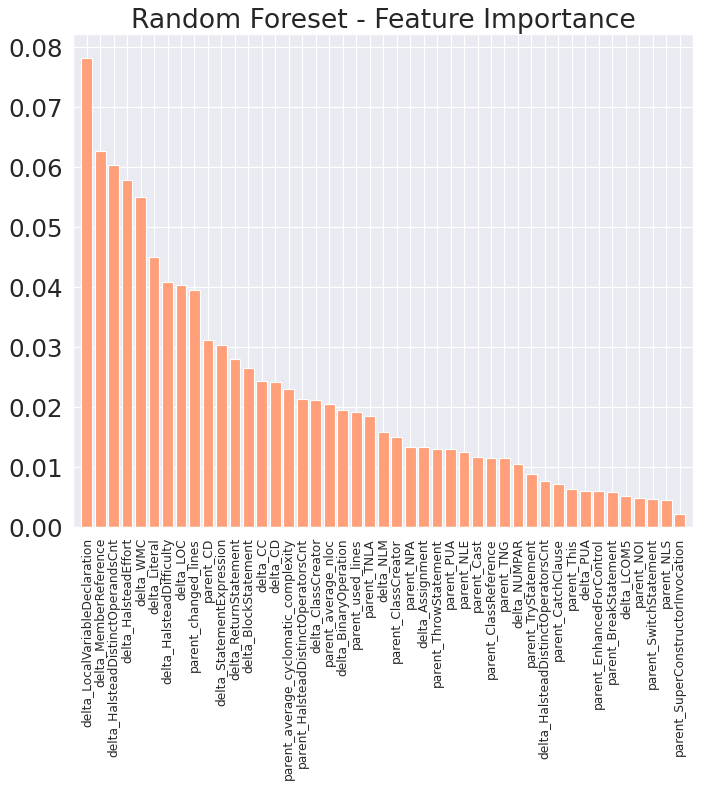

In [39]:
X = lil_matrix(X_train).toarray()
y= lil_matrix(y_train).toarray()
# print(X.shape, y.shape)
feature_names= list(X_train.columns.values)

# define the model
rf = RandomForestClassifier()
# fit the model
rf.fit(X, y)
# get importance
importance = rf.feature_importances_
indices = np.argsort(importance)[::-1]
plt.figure(figsize=(10, 8), dpi=80)
plt.title("Random Foreset - Feature Importance")
plt.bar(range(X.shape[1]), importance[indices],
        color="lightsalmon", align="center")
plt.xticks(range(X.shape[1]), np.array(feature_names)[indices.astype(int)], rotation=90, fontsize=11)
plt.xlim([-1, X.shape[1]])
plt.show()

Choosing the top 15 features:

In [40]:
top_indices = np.argsort(importance)[-15:]
rf_selected_features = list(np.array(feature_names)[top_indices.astype(int)])
rf_selected_features

['delta_CD',
 'delta_CC',
 'delta_BlockStatement',
 'delta_ReturnStatement',
 'delta_StatementExpression',
 'parent_CD',
 'parent_changed_lines',
 'delta_LOC',
 'delta_HalsteadDifficulty',
 'delta_Literal',
 'delta_WMC',
 'delta_HalsteadEffort',
 'delta_HalsteadDistinctOperandsCnt',
 'delta_MemberReference',
 'delta_LocalVariableDeclaration']

Computing mutual information (MI) for feature selection:

In [41]:
from sklearn.feature_selection import mutual_info_classif

# Initialize a DataFrame to store MI scores for each label
mi_scores_per_label = pd.DataFrame(index=X_train.columns)

# Compute MI scores for each label
for label in y_train.columns:
    mi_scores = mutual_info_classif(X_train, y_train[label])
    mi_scores_per_label[label] = mi_scores

# Aggregate MI scores across labels
# Here we use the mean, but you can use other methods like sum or max
mi_scores_mean = mi_scores_per_label.mean(axis=1)
mi_scores_mean = mi_scores_mean.sort_values(ascending=False)

# Display the feature scores
# print(mi_scores_mean)

threshold = mi_scores_mean.mean(axis=0)
mi_selected_features = list(mi_scores_mean[mi_scores_mean > threshold].index)
mi_selected_features

['delta_HalsteadEffort',
 'delta_MemberReference',
 'delta_HalsteadDistinctOperandsCnt',
 'delta_HalsteadDifficulty',
 'delta_LocalVariableDeclaration',
 'delta_WMC',
 'delta_Literal',
 'delta_LOC',
 'delta_StatementExpression',
 'delta_BlockStatement',
 'delta_NLM',
 'delta_CD',
 'delta_ReturnStatement',
 'delta_BinaryOperation',
 'delta_ClassCreator',
 'delta_HalsteadDistinctOperatorsCnt',
 'delta_CC',
 'delta_LCOM5',
 'parent_changed_lines',
 'delta_Assignment',
 'delta_NUMPAR']

Combine all the features from both FS methods:


In [42]:
# Convert lists to sets
set1 = set(mi_selected_features)
set2 = set(rf_selected_features)

# Union the sets
combined_set = set1.union(set2)

# Convert back to list (optional)
features = list(combined_set)

# Print the combined list
features


['delta_NLM',
 'delta_BlockStatement',
 'delta_WMC',
 'delta_CC',
 'delta_HalsteadDistinctOperatorsCnt',
 'delta_CD',
 'delta_BinaryOperation',
 'delta_HalsteadDistinctOperandsCnt',
 'delta_LocalVariableDeclaration',
 'delta_ClassCreator',
 'delta_NUMPAR',
 'delta_Assignment',
 'delta_HalsteadDifficulty',
 'delta_MemberReference',
 'delta_StatementExpression',
 'delta_HalsteadEffort',
 'delta_LOC',
 'parent_changed_lines',
 'delta_LCOM5',
 'delta_ReturnStatement',
 'parent_CD',
 'delta_Literal']

In [43]:
X_train = X_train.drop(list(filter(lambda x: x not in features, X_train.columns)), axis=1, inplace = False)
X_test = X_test.drop(list(filter(lambda x: x not in features, X_test.columns)), axis=1, inplace = False)
X_train.shape

(828, 22)

#### Labels distributation plot :

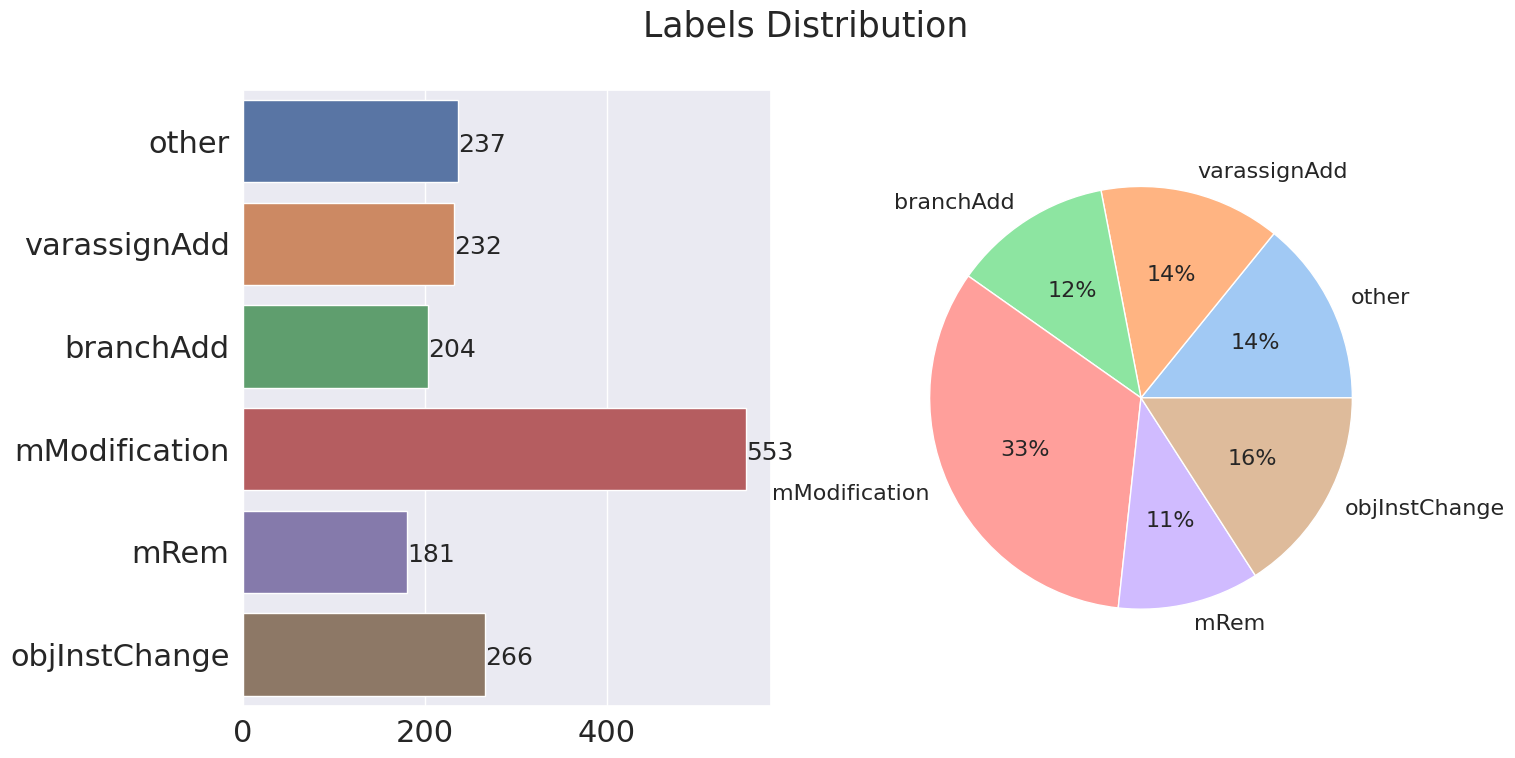

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
fig.suptitle('Labels Distribution',fontsize=25)

#define data
data = y_train.astype(bool).sum().values
categories_final = list(y_train.columns.values)

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:12]

#create pie chart
ax2.pie(data, labels = categories_final, colors = colors, autopct='%.0f%%', textprops={'fontsize':16})
ax1 = sns.barplot(x=y_train.astype(bool).sum().values, y=list(y_train.columns.values), ax=ax1, orient='h')

rects = ax1.patches
labels = y_train.astype(bool).sum().values
for rect, label in zip(rects, labels):
    height = rect.get_y()
    ax1.text(rect.get_x() + rect.get_width(), height+0.5 , label, fontsize=18)

plt.show()

From the above plots, we can see that the data is imbalanced. This imbalance can create a big challenge for the model tasks and lead to poor predictive performance for the minority class.

To overcome the data imbalance problem, we can use various methods and techniques, and data augmentation is one of those. In this project, I will use a popular data augmentation approach for imbalanced multi-label data, known as multi-label synthetic minority over-sampling (MLSMOTE).

### Data Augmentation

#### MLSMOTE algorithm

In [ ]:
def get_tail_label(df):
    """
    Give tail label colums of the given target dataframe

    args
    df: pandas.DataFrame, target label df whose tail label has to identified

    return
    tail_label: list, a list containing column name of all the tail label
    """
    columns = df.columns
    n = len(columns)
    irpl = np.zeros(n)
    for column in range(n):
        irpl[column] = df[columns[column]].value_counts()[1]
    irpl = max(irpl)/irpl
    mir = np.average(irpl)
    tail_label = []
    for i in range(n):
        if irpl[i] > mir:
            tail_label.append(columns[i])
    return tail_label

def get_index(df):
    """
    give the index of all tail_label rows
    args
    df: pandas.DataFrame, target label df from which index for tail label has to identified

    return
    index: list, a list containing index number of all the tail label
    """
    tail_labels = get_tail_label(df)
    index = set()
    for tail_label in tail_labels:
        sub_index = set(df[df[tail_label]==1].index)
        index = index.union(sub_index)
    return list(index)

def get_minority_instace(X, y):
    """
    Give minority dataframe containing all the tail labels

    args
    X: pandas.DataFrame, the feature vector dataframe
    y: pandas.DataFrame, the target vector dataframe

    return
    X_sub: pandas.DataFrame, the feature vector minority dataframe
    y_sub: pandas.DataFrame, the target vector minority dataframe
    """
    index = get_index(y)
    X_sub = X[X.index.isin(index)].reset_index(drop = True)
    y_sub = y[y.index.isin(index)].reset_index(drop = True)
    return X_sub, y_sub

def nearest_neighbour(X):
    """
    Give index of 5 nearest neighbor of all the instance

    args
    X: np.array, array whose nearest neighbor has to find

    return
    indices: list of list, index of 5 NN of each element in X
    """
    nbs=NearestNeighbors(n_neighbors=5,metric='euclidean',algorithm='kd_tree').fit(X)
    euclidean,indices= nbs.kneighbors(X)
    return indices

def MLSMOTE(X,y, n_sample):
    """
    Give the augmented data using MLSMOTE algorithm

    args
    X: pandas.DataFrame, input vector DataFrame
    y: pandas.DataFrame, feature vector dataframe
    n_sample: int, number of newly generated sample

    return
    new_X: pandas.DataFrame, augmented feature vector data
    target: pandas.DataFrame, augmented target vector data
    """
    indices2 = nearest_neighbour(X)
    n = len(indices2)
    new_X = np.zeros((n_sample, X.shape[1]))
    target = np.zeros((n_sample, y.shape[1]))
    for i in range(n_sample):
        reference = random.randint(0,n-1)
        neighbour = random.choice(indices2[reference,1:])
        all_point = indices2[reference]
        nn_df = y[y.index.isin(all_point)]
        ser = nn_df.sum(axis = 0, skipna = True)
        target[i] = np.array([1 if val>2 else 0 for val in ser])
        ratio = random.random()
        gap = X.loc[reference,:] - X.loc[neighbour,:]
        new_X[i] = np.array(X.loc[reference,:] + ratio * gap)
    new_X = pd.DataFrame(new_X, columns=X.columns)
    target = pd.DataFrame(target, columns=y.columns)
    new_X = pd.concat([X, new_X], axis=0)
    target = pd.concat([y, target], axis=0)
    return new_X, target

Creating 1000 more intances of the minority label

In [ ]:
X_sub, y_sub = get_minority_instace(X_train, y_train)
X_res, y_res =MLSMOTE(X_sub, y_sub, 1000)

X_res.reset_index(drop=True,inplace=True)
y_res.reset_index(drop=True,inplace=True)

#Combining the real and synthetic data-sets
X_balanced = pd.concat([X_train, X_res])
X_balanced.reset_index(drop=True,inplace=True)

y_balanced = pd.concat([y_train, y_res])
y_balanced.reset_index(drop=True,inplace=True)

Check again for labels distributation:

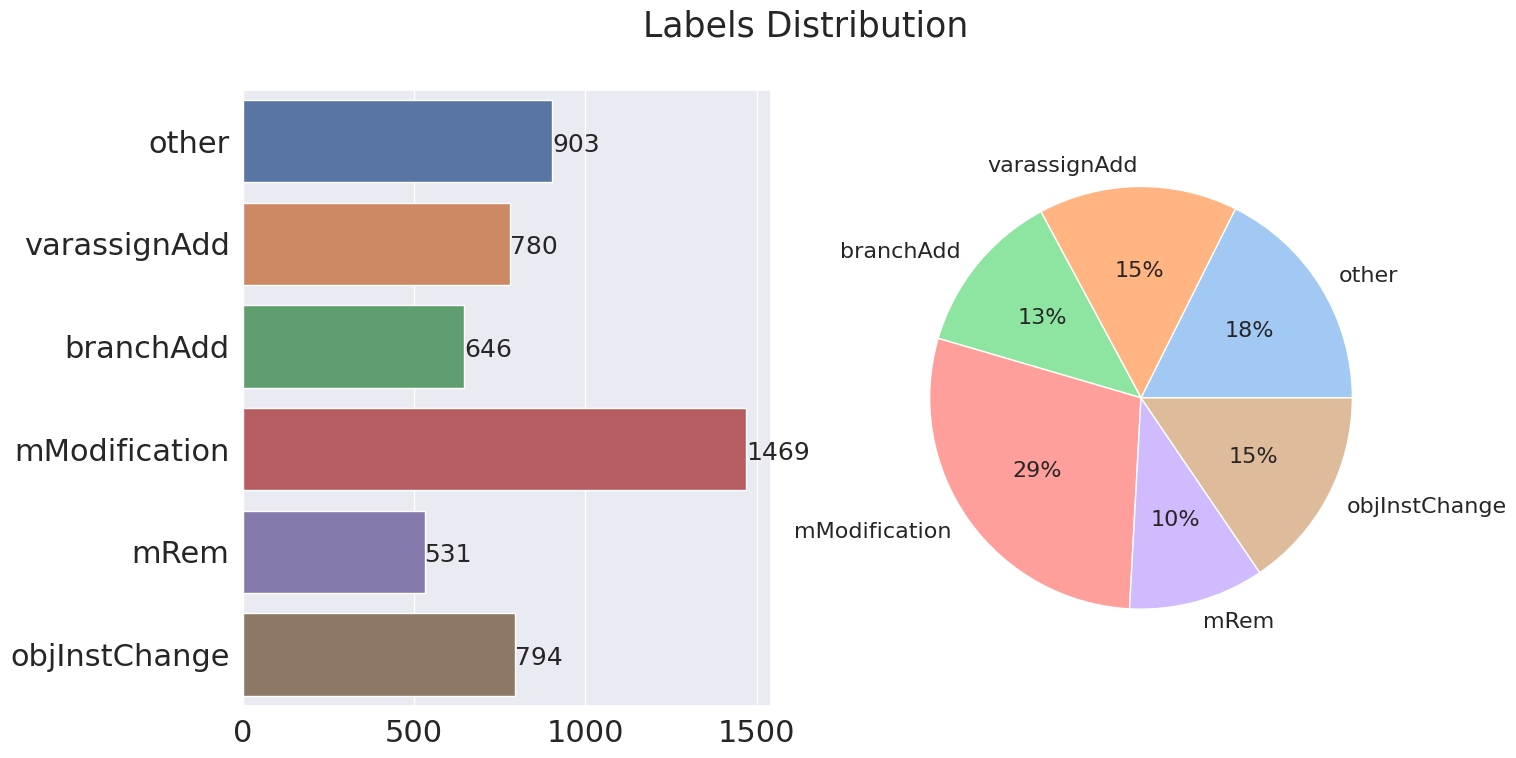

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
fig.suptitle('Labels Distribution',fontsize=25)

#define data
data = y_balanced.astype(bool).sum().values
categories_final_balanced = list(y_balanced.columns.values)

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:12]



#create pie chart
ax2.pie(data, labels = categories_final_balanced, colors = colors, autopct='%.0f%%', textprops={'fontsize':16})
ax1 = sns.barplot(x=data, y=list(y_balanced.columns.values), ax=ax1, orient='h')

rects = ax1.patches
labels = data
for rect, label in zip(rects, labels):
    height = rect.get_y()
    ax1.text(rect.get_x() + rect.get_width(), height+0.5 , label, fontsize=18)

plt.show()

## 3. Model Training & Evaluation

In [45]:
label_names = list(y_train.columns.values)
X_train = lil_matrix(X_train).toarray()
y_train = lil_matrix(y_train).toarray()
X_test = lil_matrix(X_test).toarray()
y_test = lil_matrix(y_test).toarray()

### Baseline Model - DummyClassifier model



In [46]:
dummy_clf = DummyClassifier(strategy='stratified')
dummy_clf.fit(X_train, y_train)
# dummy_clf.score(X_train, y_train)

yhat_dummy_clf = dummy_clf.predict(X_test)
# round probabilities to class labels
yhat_dummy_clf = yhat_dummy_clf.round()
# Evaluate Model
print(classification_report(y_test, yhat_dummy_clf,target_names=label_names, zero_division=0))

               precision    recall  f1-score   support

        other       0.24      0.29      0.26        59
 varassignAdd       0.21      0.21      0.21        57
    branchAdd       0.28      0.30      0.29        43
mModification       0.65      0.64      0.65       138
         mRem       0.29      0.25      0.27        55
objInstChange       0.29      0.30      0.29        70

    micro avg       0.39      0.39      0.39       422
    macro avg       0.33      0.33      0.33       422
 weighted avg       0.39      0.39      0.39       422
  samples avg       0.38      0.41      0.35       422



### XGBoost model

XGBoost Hyper-Parameters tuning:

In [47]:
f1_scorer = make_scorer(f1_score, average='micro')

# Define the parameter grid
param_grid = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__learning_rate': [0.01, 0.05, 0.1],
    'estimator__max_depth': [3, 5, 7],
    'estimator__min_child_weight': [1, 3, 5],
    'estimator__gamma': [0, 0.1, 0.2],
    'estimator__subsample': [0.7, 0.8, 0.9]
}

# Create a XGBClassifier
xgb_clf = MultiOutputClassifier(XGBClassifier())

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1, scoring=f1_scorer)
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best micro f1-score: ", grid_search.best_score_)


Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Best parameters found:  {'estimator__gamma': 0.2, 'estimator__learning_rate': 0.05, 'estimator__max_depth': 7, 'estimator__min_child_weight': 1, 'estimator__n_estimators': 100, 'estimator__subsample': 0.8}
Best micro f1-score:  0.8443871017294972


XGBoost testing the model using the best parameters:

In [48]:
# Create the MultiOutputClassifier with XGBClassifier
multioutput_classifier = MultiOutputClassifier(XGBClassifier(n_estimators = 100, gamma = 0, learning_rate = 0.05, max_depth = 7, min_child_weight = 1, subsample = 0.8))

# Train the model
multioutput_classifier.fit(X_train, y_train)

MultiOutputClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=0,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=0.05, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=7,
                                              max_leaves=None,
                                              min_child_weight=1, missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...))

In [49]:
# Making predictions
predictions = multioutput_classifier.predict(X_test)

# Evaluating the model
# Calculating F1-score for each label
for i in range(y_test.shape[1]):
    f1 = f1_score(y_test[:, i], predictions[:, i], average='binary')
    print(f"Label {i} F1-Score: {f1}")

# Calculating overall F1-score (micro average)
f1_micro = f1_score(y_test, predictions, average='micro')
print(f"Overall F1-Score (Micro Average): {f1_micro}")

# Calculating overall F1-score (macro average)
f1_macro = f1_score(y_test, predictions, average='macro')
print(f"Overall F1-Score (Macro Average): {f1_macro}")


Label 0 F1-Score: 0.7787610619469028
Label 1 F1-Score: 0.9217391304347825
Label 2 F1-Score: 0.853932584269663
Label 3 F1-Score: 0.9154929577464788
Label 4 F1-Score: 0.6590909090909091
Label 5 F1-Score: 0.7647058823529412
Overall F1-Score (Micro Average): 0.8387878787878787
Overall F1-Score (Macro Average): 0.8156204209736129


### Deep Neural Network model

Hyper-parameters tuning

In [53]:
from keras.metrics import Metric

class F1Score(Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(y_pred)
        y_true = tf.cast(y_true, tf.float32)  # Cast y_true to float32
        y_pred = tf.cast(y_pred, tf.float32)
        tp = tf.reduce_sum(y_true * y_pred, axis=0)
        fp = tf.reduce_sum((1 - y_true) * y_pred, axis=0)
        fn = tf.reduce_sum(y_true * (1 - y_pred), axis=0)

        self.true_positives.assign_add(tf.reduce_sum(tp))
        self.false_positives.assign_add(tf.reduce_sum(fp))
        self.false_negatives.assign_add(tf.reduce_sum(fn))

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
        return f1

    def reset_states(self):
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)


In [54]:
def create_model(neurons=10, activation='relu', dropout_rate=0.3):
    model = Sequential()
    model.add(Dense(neurons, input_dim=X_train.shape[1], activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(y_train.shape[1], activation='sigmoid'))  # Sigmoid for multi-label classification
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[F1Score()])
    return model


In [55]:
f1_scorer = make_scorer(f1_score, average='micro')
model = KerasClassifier(model=create_model)

# Define the grid search parameters
param_grid = {
    'model__neurons': [10, 20, 30],
    'batch_size': [16, 32, 64],
    'optimizer__learning_rate': [0.0001, 0.001, 0.01, 0.1],
    'epochs': [10, 20]
}

# Create Grid Search
grid = GridSearchCV(estimator= model, param_grid=param_grid, n_jobs=-1, cv=3, scoring=f1_scorer)
# print(grid.get_params().keys())
grid_result = grid.fit(X_train, y_train)

# Print results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Epoch 1/20
52/52 [==============================] - 1s 2ms/step - loss: 0.7163 - f1_score: 0.4783
Epoch 2/20
52/52 [==============================] - 0s 2ms/step - loss: 0.6436 - f1_score: 0.5480
Epoch 3/20
32/52 [=================>............] - ETA: 0s - loss: 0.6041 - f1_score: 0.5576

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:2723: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


52/52 [==============================] - 0s 2ms/step - loss: 0.5949 - f1_score: 0.5771
Epoch 4/20
52/52 [==============================] - 0s 2ms/step - loss: 0.5651 - f1_score: 0.5974
Epoch 5/20
52/52 [==============================] - 0s 2ms/step - loss: 0.5510 - f1_score: 0.6085
Epoch 6/20
52/52 [==============================] - 0s 2ms/step - loss: 0.5248 - f1_score: 0.6153
Epoch 7/20
52/52 [==============================] - 0s 2ms/step - loss: 0.5147 - f1_score: 0.6081
Epoch 8/20
52/52 [==============================] - 0s 2ms/step - loss: 0.5021 - f1_score: 0.6079
Epoch 9/20
52/52 [==============================] - 0s 2ms/step - loss: 0.4870 - f1_score: 0.6223
Epoch 10/20
52/52 [==============================] - 0s 2ms/step - loss: 0.4799 - f1_score: 0.6240
Epoch 11/20
52/52 [==============================] - 0s 2ms/step - loss: 0.4691 - f1_score: 0.6311
Epoch 12/20
52/52 [==============================] - 0s 2ms/step - loss: 0.4655 - f1_score: 0.6341
Epoch 13/20
52/52 [=========

In [56]:
# get the model
def get_model(input_dim):
    model = Sequential()
    model.add(Dense(30, input_dim=input_dim, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(y_train.shape[1], activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer = 'adam')
    return model


# define model
model = get_model(X_train.shape[1])
# fit model
model.fit(X_train, y_train, verbose=0, epochs=20, batch_size=16)
# make a prediction on the test set
yhat = model.predict(X_test)
# round probabilities to class labels
yhat = yhat.round()
# Evaluate Model
#  print(f'{x}:\n' ,classification_report(globals()['y_%s_test' % x], yhat,target_names=label_names, zero_division=0, **output_dict=True**))
report=classification_report(y_test, yhat,target_names=label_names, zero_division=0, output_dict=True)
print(report)

7/7 [==============================] - 0s 2ms/step
{'other': {'precision': 0.8260869565217391, 'recall': 0.6440677966101694, 'f1-score': 0.7238095238095238, 'support': 59}, 'varassignAdd': {'precision': 0.8372093023255814, 'recall': 0.631578947368421, 'f1-score': 0.72, 'support': 57}, 'branchAdd': {'precision': 0.7804878048780488, 'recall': 0.7441860465116279, 'f1-score': 0.761904761904762, 'support': 43}, 'mModification': {'precision': 0.8461538461538461, 'recall': 0.8768115942028986, 'f1-score': 0.8612099644128114, 'support': 138}, 'mRem': {'precision': 0.7, 'recall': 0.2545454545454545, 'f1-score': 0.3733333333333333, 'support': 55}, 'objInstChange': {'precision': 0.7708333333333334, 'recall': 0.5285714285714286, 'f1-score': 0.6271186440677967, 'support': 70}, 'micro avg': {'precision': 0.8152492668621701, 'recall': 0.6587677725118484, 'f1-score': 0.72870249017038, 'support': 422}, 'macro avg': {'precision': 0.7934618738687581, 'recall': 0.613293544635, 'f1-score': 0.677896037921371

In [ ]:
def f1_score(y_true, y_pred):
    y_pred = tf.round(y_pred)  # Round the predictions to the nearest integer (threshold=0.5)
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32), axis=0)
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, tf.float32), axis=0)
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), tf.float32), axis=0)

    p = tp / (tp + fp + tf.keras.backend.epsilon())
    r = tp / (tp + fn + tf.keras.backend.epsilon())

    f1 = 2*p*r / (p + r + tf.keras.backend.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return tf.reduce_mean(f1)

def create_model_wrapper(neurons=10, activation='relu'):
    def create_model():
        model = Sequential()
        model.add(Dense(neurons, input_dim=X_train.shape[1], activation=activation))
        model.add(Dense(neurons, activation=activation))  # Additional layers
        model.add(Dense(y_train.shape[1], activation='sigmoid'))  # Output layer
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1_score])
        return model
    return create_model

# Define the grid search parameters
param_grid = {
    'neurons': [10, 20, 30],
    'activation': ['relu', 'tanh'],
    'batch_size': [16, 32, 64],
    'epochs': [10, 20]
}

# Run Grid Search for each combination of parameters
best_score = 0
best_params = None
for neurons in param_grid['neurons']:
    for activation in param_grid['activation']:
        model = KerasClassifier(model=create_model_wrapper(neurons, activation),
                                batch_size=32, epochs=10, verbose=0)
        model.fit(X_train, y_train)
        score = model.score(X_test, y_test)
        if score > best_score:
            best_score = score
            best_params = {'neurons': neurons, 'activation': activation}

print("Best Score: %f" % best_score)
print("Best Params:", best_params)

In [ ]:
# get the model
def get_model(optimizer):
    model = Sequential()
    model.add(Dense(20, input_dim=16, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(5, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer)
    return model

# create model
model = KerasClassifier(model=get_model, verbose=0)
# model = KerasClassifier(model=get_model,epochs=150, batch_size=32 verbose=0)

# Grid search parameters
neurons = [20, 30]
batch_size = [32,64]
epochs = [500, 700, 1000]
learn_rate = [0.0001, 0.001, 0.01, 0.1]
# momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
optimizers = ['SGD', 'Adam']
# param_grid = dict(optimizer__learning_rate=learn_rate, optimizer__momentum=momentum)
param_grid = dict(batch_size=batch_size, epochs=epochs, model__neurons=neurons, optimizer__learning_rate=learn_rate, optimizer = optimizers)
# param_grid = dict(epochs=epochs)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, scoring='f1_samples', return_train_score = True)
grid_result = grid.fit(X_train, y_train)


# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


# Plot the f1_samples_score as function of number of epoches

fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(epochs,(grid_result.cv_results_['mean_train_score']), 'r', label='Training')
ax.plot(epochs,(grid_result.cv_results_['mean_test_score']), 'b' ,label='Validation')
ax.set_xlabel(r'Epochs', fontsize=20)
ax.set_ylabel(r'F1_Samples_Score', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)


Testing the model using the best parameters:

In [ ]:
# get the model
def get_model(input_dim):
    model = Sequential()
    model.add(Dense(20, input_dim=input_dim, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(y_train.shape[1], activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer = 'adam')
    return model


# define model
model = get_model(X_train.shape[1])
# fit model
model.fit(X_train, y_train, verbose=0, epochs=1000, batch_size=32)
# make a prediction on the test set
yhat = model.predict(X_test)
# round probabilities to class labels
yhat = yhat.round()
# Evaluate Model
#  print(f'{x}:\n' ,classification_report(globals()['y_%s_test' % x], yhat,target_names=label_names, zero_division=0, **output_dict=True**))
report=classification_report(y_test, yhat,target_names=label_names, zero_division=0, output_dict=True)
print(report)

7/7 [==============================] - 0s 3ms/step
{'other': {'precision': 0.7, 'recall': 0.8305084745762712, 'f1-score': 0.7596899224806201, 'support': 59}, 'varassignAdd': {'precision': 0.875, 'recall': 0.8596491228070176, 'f1-score': 0.8672566371681416, 'support': 57}, 'branchAdd': {'precision': 0.7291666666666666, 'recall': 0.813953488372093, 'f1-score': 0.7692307692307692, 'support': 43}, 'mModification': {'precision': 0.8828125, 'recall': 0.8188405797101449, 'f1-score': 0.8496240601503758, 'support': 138}, 'mRem': {'precision': 0.8125, 'recall': 0.4727272727272727, 'f1-score': 0.5977011494252874, 'support': 55}, 'objInstChange': {'precision': 0.7962962962962963, 'recall': 0.6142857142857143, 'f1-score': 0.6935483870967742, 'support': 70}, 'micro avg': {'precision': 0.8118556701030928, 'recall': 0.7464454976303317, 'f1-score': 0.7777777777777778, 'support': 422}, 'macro avg': {'precision': 0.7992959104938272, 'recall': 0.734994108746419, 'f1-score': 0.7561751542586613, 'support': 

### Results

The results below are separated into three plots (Precision/Recall/F1), and each plot presents the macro avg, micro avg, weighted avg, and sample avg scores for the three different sub-set of features: Kmode, Kendall, and Louvain.

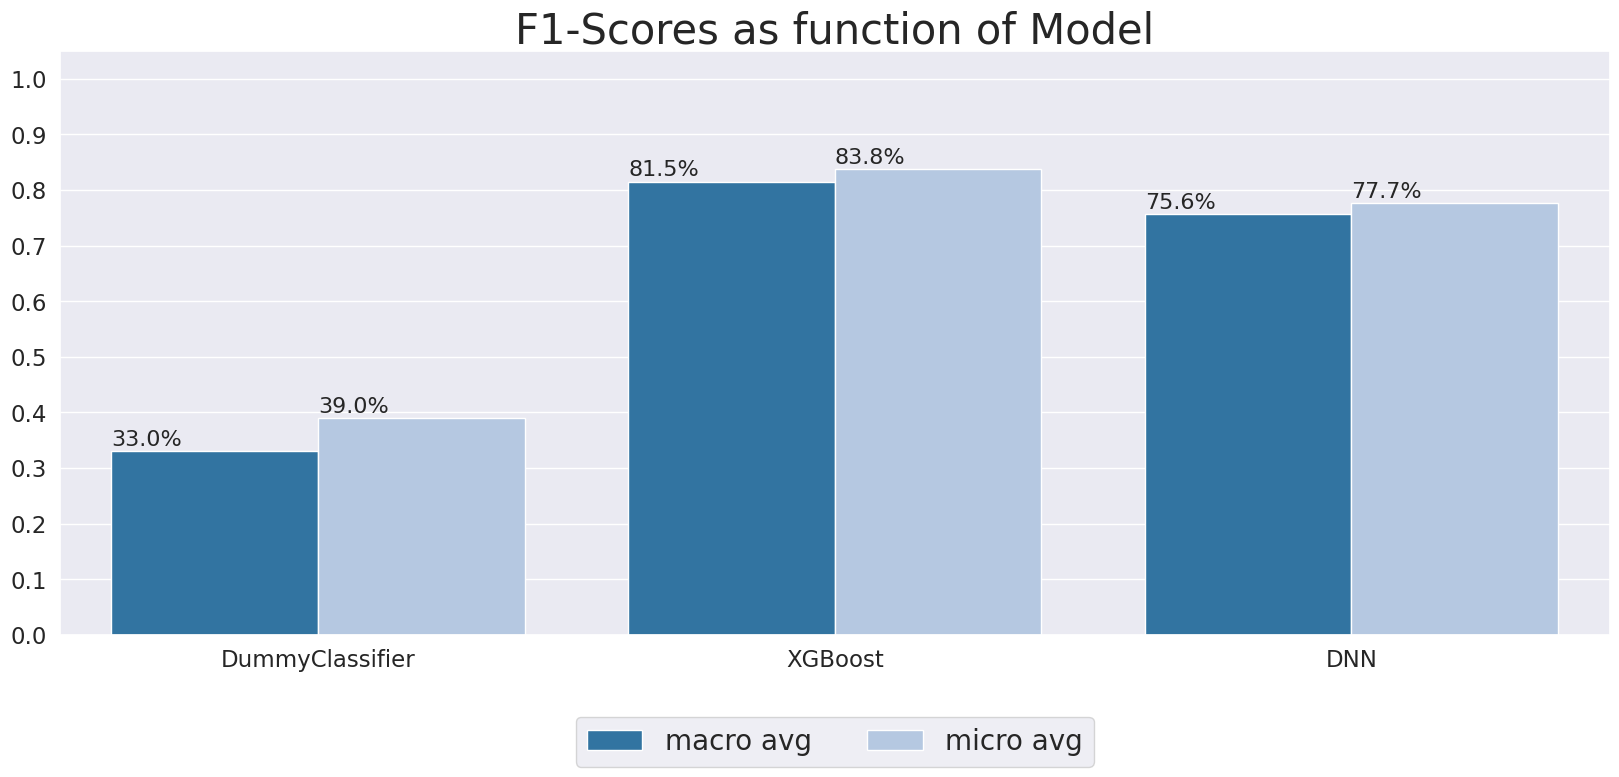

In [52]:
result_precision = pd.DataFrame(columns=['Model', 'macro avg', 'micro avg'])

result_precision = pd.concat([result_precision, pd.DataFrame.from_dict(
{ 'Model':'DummyClassifier',
 'macro avg': 0.33,
 'micro avg': 0.39
}, orient='index').transpose()])

result_precision = pd.concat([result_precision, pd.DataFrame.from_dict(
{ 'Model':'XGBoost',
 'macro avg': 0.815,
 'micro avg': 0.838
}, orient='index').transpose()])

result_precision = pd.concat([result_precision, pd.DataFrame.from_dict(
{ 'Model':'DNN',
 'macro avg': 0.756,
 'micro avg': 0.777
}, orient='index').transpose()])

result_precision = pd.melt(result_precision, id_vars=['Model'], value_vars=['macro avg', 'micro avg']).rename(columns={'variable':'Metric', 'value':'Value'})

sns.set(font_scale = 1.5)
fig, ax = plt.subplots(figsize=(20, 8))
plt.gcf().subplots_adjust(bottom=0.15)
sns.barplot(ax=ax, x='Model', y='Value', hue='Metric', hue_order=['macro avg', 'micro avg'], data=result_precision,
            order=['DummyClassifier','XGBoost','DNN'],
           palette=sns.color_palette('tab20'))
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=3, fontsize=20)
for patch in ax.patches:
    ax.text(patch.get_x(), patch.get_height()+0.01, '{:.1%}'.format(patch.get_height()), fontsize=16)
ax.set_title('F1-Scores as function of Model', fontsize=30)
ax.set_xlabel(' ')
ax.set_ylabel(None)
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_ylim((0, 1.05))
plt.show()
